In [1]:
import os
import glob

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from collections import Counter

from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize

import datetime

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [3]:
from sklearn.naive_bayes import MultinomialNB

from sklearn import metrics

## define helper functions

In [4]:
# initialize 7 margins
margins = {'amount': 600,
          'authorization': 600,
          'date' : 600,
          'count' : 600,
          'intention' : 600,
          'utilization':600,
          'unknown':600}

In [124]:
dkfn_kts_dict.keys()
dkfn_kts_dict['auth_kts']

,key_tok,kt_count
0,repurchase,259
1,board,224
2,authorized,202
3,directors,185
4,program,125
5,company,92
6,share,78
7,approved,62
8,stock,54
9,additional,51


In [5]:
def get_relevant_key_word_tokens(df_col, most_common = 10, inverse = False, least_common = 10):
    '''Takes a data frame and column name and returns a list of key word tokens. If inverse, then it will return the 10 least common tokens'''
    # make sure the column is strings
    for cell in df_col:
        assert(type(cell) == str)
    text_list = [t.lower() for t in df_col]
    text_string = ''
    for t in text_list:
        text_string = text_string + t + ' '
    text_tokens = [w for w in word_tokenize(text_string) if (w.isalnum() and w not in stopwords.words('english'))]
    if inverse:
        key_tokens = pd.DataFrame(Counter(text_tokens).most_common()).tail(10)
    else:
        key_tokens = pd.DataFrame(Counter(text_tokens).most_common(most_common))

    key_tokens.columns = ['key_tok', 'kt_count']
    
    return key_tokens


def define_nominated_paragraphs(filing, key_tokens, margin):
    '''takes an html filing, key_tokens, paragraph margin and returns nominated paragraphs'''
    
    # read in an html
    with open(filing) as file:
        file_html = file.read()
        
    # parse html
    parsed_html = BeautifulSoup(file_html, 'lxml')
    # filter out the html head, css, and cast to lower case
    string_filing = parsed_html.body.text.lower()
    
    ##################------- Predict Paragraphs ------##############################################
    #define candidate paragraphs by addin margins to each hit
    #
    #------ generate a list of token mathces / "hits"------------------------------
    #
    # collect the start and end indices of each token "hit." into an ugly list of lists of tuples
    lst_of_token_hits_lst = []
    for i in range(len(key_tokens.key_tok[0:10])):
        kt = key_tokens.key_tok[i]
        lst_of_token_hits_lst.append([(str(kt), m.start(), m.end()) for m in re.finditer(kt, string_filing)])
    #
    # flatten the ugly list of lists of tuples into a list of tuples
    flater_list_of_tokhits = [tpl for sublist in lst_of_token_hits_lst for tpl in sublist]
    #
    # order the list of token_hit tuples by starting index
    flater_list_of_tokhits.sort(key = lambda x: x[1])
    #
    #-------- use the token hits to define the bounds of the candidate paragraphs -------
    #
    # initialize a list of candidate paragraph bounds
    candidate_paragraphs = []
    
    for i in range(len(flater_list_of_tokhits)):
    #    
    #    # initialize the left and right bound of a paragraph
        leftbound = flater_list_of_tokhits[i][1] - margin
        rightbound = flater_list_of_tokhits[i][2] + margin
        
        # ensure bounds are not out of index range
        if leftbound < 0:
            leftbound = 0
        if rightbound > len(string_filing):
            rightbound = len(string_filing)

        par_bounds = (leftbound, rightbound) 
        candidate_paragraphs.append(par_bounds)
    
    return candidate_paragraphs, string_filing

In [68]:
# for predicted paragraph
def measure_inclusion(predicted_par, test_par, verbose = False):
    
    # pre process paragraphs and generate tokens
    pred = re.sub(r'\n+', ' ', predicted_par)
    pred = re.sub(r'\s+', ' ', pred)
    pred = pred.lower()
    pred_tokens = [wt for wt in word_tokenize(pred) if (wt.isalnum() and wt not in stopwords.words('english'))]
    if len(pred) == 0:
        pred_tokens = [None]
    
    test = re.sub(r'\n+', ' ', test_par)
    test = re.sub(r'\s+', ' ', test)
    test = test.lower()
    test_tokens = [wt for wt in word_tokenize(test) if (wt.isalnum() and wt not in stopwords.words('english'))]
    
    # calculate total inclusion
    total_inclusion = False
    if test in pred:
        total_inclusion = True
    # calculate test-inclusion percentage ()
    counter = 0
    for wt in test_tokens:
        if wt in pred_tokens:
            counter +=1
    inclusion_pct = round(100*counter/len(test_tokens), 2)
    
    # calculate extra baggage percentage
    bag_counter = 0
    for wt in pred_tokens:
        if wt not in test_tokens:
            bag_counter += 1
    baggage_pct = round(100*bag_counter/len(pred_tokens), 2)
    
    # package results for output
    results = {'total_inclusion' : total_inclusion,
              'inclusion_pct' : inclusion_pct,
              'baggage_pct': baggage_pct,
              'pred_tokenized_par_len': len(pred_tokens),
              'test_tokenized_par_len': len(test_tokens)}
    
    # reporting
    if verbose == True:
        print(results)
    
    return results
    

In [66]:
def get_model_paragraph(nom_pars, string_filing, model = 'token_density', key_tokens = None, vectorizer = None, verbose = False, inverse = False):
    '''takes a list of tuples of nominated paragraph bounds and a their corresponding document and returns one paragraph'''
    nominee = ''
    best_proba = 0.0
    for tpl in nom_pars:
        # generate par
        par = string_filing[tpl[0]:tpl[1]]
        # pre process par
        par = re.sub(r'\n+', ' ', par)
        par = re.sub(r'\s+', ' ', par)
        
        # if the naiver bayes prediction of classification as a given dkfn's class is new_best probability
        
        if model == 'token_density' and key_tokens.key_tok[0] in par and key_tokens.key_tok[1] in par and key_tokens.key_tok[2] in par:
            #assert key_tokens != None
            hits = 0
            w_tokens = [wt for wt in word_tokenize(par) if (wt.isalnum() and wt not in stopwords.words('english'))]
            if len(w_tokens) == 0:
                print(par)
            for wt in w_tokens:
                if wt in key_tokens.key_tok.values:
                    hits += 1
            #tk_density = hits/len(w_tokens)
            #if tk_density > best_proba:
            if hits > best_proba:
                best_proba = hits
                nominee = par
                #best_proba = tk_density
            
        elif model != 'token_density':
            #assert vectorizer != None
            # tfidf_vectorize the string into a sparse matrix
            par_vectorized = vectorizer.transform([par])
        
            # if using inverse we'll select the model's least favorite predictions
            # ------------------------------ prediction of being in the class == False -------------------------------- probability of it being false
            if inverse and model.predict(par_tfidf_vectorized)[0] == 0 and model.predict_proba(par_tfidf_vectorized)[0][0] > best_proba:
                nominee = par
                best_proba = model.predict_proba(par_tfidf_vectorized)[0][0]
            
            # if not using inverse
            elif model.predict(par_tfidf_vectorized)[0] == 1 and model.predict_proba(par_tfidf_vectorized)[0][1] > best_proba:
                #print(nb_auth_classifier.predict_proba(par_tfidf_vectorized))
                nominee = par
                #print(nominee)
                best_proba = model.predict_proba(par_tfidf_vectorized)[0][1]
            
        # write the results
        results_dct = {'nominee' : nominee,
                      'best_proba' : best_proba}
    
    if verbose:
        print('best probability', best_proba)
        print('-'*100)
        print(nominee)
        print('='*100)
    
    return results_dct

## read, clean original csv

In [36]:
#read in the csv
share_rprchs_prgrph_df = pd.read_csv('data/share_repurchase_paragraphs.csv')
share_rprchs_prgrph_df.head(2)

,ticker,accession_number,data_key_friendly_name,text,data_value,reported_data_value,reported_units,paragraph_text
0,A,0001090872-17-000018,Share Repurchase Authorization Date,"May 28, 2015",20150528,20200000.00,ones,"On May 28, 2015 we announced that our board ..."
1,A,0001090872-17-000018,Share Repurchase Authorization,The 2015 share repurchase program authorizes t...,1140000000,1.14,billions,"On May 28, 2015 we announced that our board ..."


In [37]:
# get the indices of the duplicate rows
dups = list(share_rprchs_prgrph_df[share_rprchs_prgrph_df.duplicated()].index)
#dups

# drop the duplicate rows (there was probably a more elegant way to do this... )
share_rprchs_prgrph_df = share_rprchs_prgrph_df[[i not in dups for i in share_rprchs_prgrph_df.index]]
share_rprchs_prgrph_df.reset_index(inplace=True, drop = True)
#share_rprchs_prgrph_df.info()

In [38]:
print('word' in 'This Longer String with Word')
print('word' in 'This longer string with words')

False
True


In [39]:
# count the number of pre-processed cells not in their pre-processed par cell
txt_not_in_par_count = 0
untrue_dkfns = []
for i in share_rprchs_prgrph_df.index:
    # preprocess the comparison:
    txt = re.sub(r'\n+', ' ', share_rprchs_prgrph_df.text[i])
    txt = re.sub(r'\s+', ' ', txt)
    txt = txt.lower()
    partxt = re.sub(r'\n+', ' ', share_rprchs_prgrph_df.paragraph_text[i])
    partxt = re.sub(r'\s+', ' ', partxt)
    partxt = partxt.lower()
    if txt not in partxt:
        #print('found row with text not in paragraph at index ', i)
        txt_not_in_par_count +=1
        untrue_dkfns.append(share_rprchs_prgrph_df.data_key_friendly_name[i])
print('number of texts not in their row paragraph ', txt_not_in_par_count)
print('that is a percentage of ', 100*txt_not_in_par_count/len(share_rprchs_prgrph_df.index), '%')

number of texts not in their row paragraph  19
that is a percentage of  1.072234762979684 %


Turns out that with a little preprocessing only there is only a 1% non-correspondance between text and paragraph, which itself may be resolved by some other preprocessing.
- that is sufficiently small that I wouldn't worry about leaving it in there for my training and fitting. 

# Strategy 2.0
1. split csv into training and test sets
2. predict paragraphs for training set
    - 2.a) validate against actual paragraphs
3. predict paragraphs for test set
    - 3.a) validate against actual paragraphs

## 2. Predict Paragraphs for training set
**Requires:**
- margin generated from training paragraph lengths
- 7 key_tok sets generated from 7 slices of training paragraph lengths
- 7 models generated from 7 slices of training paragraph lengths

**For each row in training_df**

- identify that row's dkfn
- generate nominee paragraphs
    - using that dkfn's margin
    - using that dkfn's key_toks
- use that dkfn's model to pick one paragraph
    - use the mod.pred_proba() on the paragraphs and select the one with highest probability
- write that paragraph to the training dataframe

In [40]:
share_rprchs_prgrph_df['tknzd_tst_par_len'] = None

share_rprchs_prgrph_df['pred_par'] = None

share_rprchs_prgrph_df['pred_proba'] = None

share_rprchs_prgrph_df['tot_incl'] = None
share_rprchs_prgrph_df['inclusion_pct'] = None
share_rprchs_prgrph_df['baggage_pct'] = None
share_rprchs_prgrph_df['tknzd_pred_par_len'] = None

### fit and train a paragraph ranking model for each dkfn

In [41]:
# add encoded classification columns
dummies = pd.get_dummies(share_rprchs_prgrph_df.data_key_friendly_name)
dummies.columns = ['amount', 'authorization', 'date', 'count', 'intention', 'utilization', 'unknown']
#dummies.head(2)

In [42]:
share_rprchs_prgrph_df = pd.concat([share_rprchs_prgrph_df, dummies], axis=1)

In [43]:
share_rprchs_prgrph_df.head(1)

,ticker,accession_number,data_key_friendly_name,text,data_value,reported_data_value,reported_units,paragraph_text,tknzd_tst_par_len,pred_par,...,inclusion_pct,baggage_pct,tknzd_pred_par_len,amount,authorization,date,count,intention,utilization,unknown
0,A,0001090872-17-000018,Share Repurchase Authorization Date,"May 28, 2015",20150528,20200000.0,ones,"On May 28, 2015 we announced that our board ...",None,None,...,None,None,None,0,0,1,0,0,0,0


In [44]:
# split data into train, fit and test subsets
X_train, X_test, y_train_ix, y_test_ix = train_test_split(share_rprchs_prgrph_df.paragraph_text,
                                                   share_rprchs_prgrph_df.index, ### Watchout this is just a placeholder for now
                                                   test_size = 0.33,
                                                   random_state = 53)
# initialize a TfidfVectorizer object
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df = 0.7)

In [45]:
# transform the training data
tfidf_train = tfidf_vectorizer.fit_transform(X_train)

# transform the test data
tfidf_test = tfidf_vectorizer.transform(X_test)

In [46]:
# make and fit a model for each dkfn
nb_amnt_classifier = MultinomialNB()
nb_amnt_classifier.fit(tfidf_train, 
                       share_rprchs_prgrph_df.amount[[ix in y_train_ix for ix in share_rprchs_prgrph_df.index]])
nb_auth_classifier = MultinomialNB()
nb_auth_classifier.fit(tfidf_train, 
                       share_rprchs_prgrph_df.authorization[[ix in y_train_ix for ix in share_rprchs_prgrph_df.index]])
nb_dt_classifier = MultinomialNB()
nb_dt_classifier.fit(tfidf_train, 
                       share_rprchs_prgrph_df.date[[ix in y_train_ix for ix in share_rprchs_prgrph_df.index]])
nb_cnt_classifier = MultinomialNB()
nb_cnt_classifier.fit(tfidf_train, 
                       share_rprchs_prgrph_df['count'][[ix in y_train_ix for ix in share_rprchs_prgrph_df.index]])
nb_intent_classifier = MultinomialNB()
nb_intent_classifier.fit(tfidf_train, 
                       share_rprchs_prgrph_df.intention[[ix in y_train_ix for ix in share_rprchs_prgrph_df.index]])
nb_util_classifier = MultinomialNB()
nb_util_classifier.fit(tfidf_train, 
                       share_rprchs_prgrph_df.utilization[[ix in y_train_ix for ix in share_rprchs_prgrph_df.index]])
nb_unk_classifier = MultinomialNB()
nb_unk_classifier.fit(tfidf_train, 
                       share_rprchs_prgrph_df.unknown[[ix in y_train_ix for ix in share_rprchs_prgrph_df.index]])


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

**Validate the seven models**

In [47]:
models_lst = [nb_amnt_classifier, nb_auth_classifier, nb_cnt_classifier, nb_dt_classifier,
             nb_intent_classifier, nb_unk_classifier, nb_util_classifier]

for mod, col in zip(models_lst, ['amount', 'authorization', 'count' ,'date', 'intention', 'unknown', 'utilization']):
    pred = mod.predict(tfidf_test)
    score = metrics.accuracy_score(share_rprchs_prgrph_df[col][[ix in y_test_ix for ix in share_rprchs_prgrph_df.index]], pred)
    print(round(100*score, 1), '%', col, 'accuracy')

80.7 % amount accuracy
80.0 % authorization accuracy
84.8 % count accuracy
77.3 % date accuracy
86.3 % intention accuracy
93.2 % unknown accuracy
97.8 % utilization accuracy


### Define the dkfn slices

In [48]:
unk_df = share_rprchs_prgrph_df[share_rprchs_prgrph_df.data_key_friendly_name == 'Unknown Share Repurchase Data']
#unk_df.info()

In [49]:
util_df = share_rprchs_prgrph_df[share_rprchs_prgrph_df.data_key_friendly_name == 'Share Repurchase Utilization']
#util_df.info()

In [50]:
shrp_intent_df = share_rprchs_prgrph_df[share_rprchs_prgrph_df.data_key_friendly_name == 'Share Repurchase Intention']
#shrp_intent_df.info()

In [51]:
shrp_count_df = share_rprchs_prgrph_df[share_rprchs_prgrph_df.data_key_friendly_name == 'Share Repurchase Count']
#shrp_count_df.info()

In [52]:
auth_dt_df = share_rprchs_prgrph_df[share_rprchs_prgrph_df.data_key_friendly_name == 'Share Repurchase Authorization Date']
#auth_dt_df.info()

In [53]:
auth_df = share_rprchs_prgrph_df[share_rprchs_prgrph_df.data_key_friendly_name == 'Share Repurchase Authorization']
#auth_df.info()

In [54]:
amnt_spnt_df = share_rprchs_prgrph_df[share_rprchs_prgrph_df.data_key_friendly_name == 'Amount Spent on Share Repurchases']
#amnt_spnt_df.info()

In [55]:
# spot check that the text column is only strings
for c in share_rprchs_prgrph_df.text:
    assert(type('str') == type(c))

In [56]:
dkfn_slices = [unk_df, util_df, shrp_count_df, shrp_intent_df, 
               auth_df, auth_dt_df, amnt_spnt_df]

In [57]:
type(dkfn_slices[0])

pandas.core.frame.DataFrame

## generate key_token for each dkfn
### store key_tokens and models in dictionaries for later use

In [58]:
## use dictionary to assign models in loop
'''[nb_amnt_classifier, nb_auth_classifier, nb_cnt_classifier, nb_dt_classifier,
             nb_intent_classifier, nb_unk_classifier, nb_util_classifier]'''

models_dict ={}
for mdl, k in zip(models_lst,
                 ['spent_model', 'auth_model', 'count_model', 'date_model', 
                  'intent_model', 'unk_model', 'util_model']):
    models_dict['{0}'.format(k)] = mdl


In [59]:
# use dictionary to assign variables in loop:
dkfn_kts_dict = {}
for slc, k in zip(dkfn_slices, 
                  ['unk_kts', 'util_kts', 'count_kts', 'intent_kts', 'auth_kts', 'date_kts', 'spent_kts']):
    dkfn_kts_dict['{0}'.format(k)] = get_relevant_key_word_tokens(slc.text)
    
#print(dkfn_kts_dict)

In [60]:
dkfn_kts_dict['unk_kts']

,key_tok,kt_count
0,repurchase,74
1,board,54
2,authorized,52
3,directors,49
4,program,31
5,shares,25
6,company,24
7,authorization,18
8,share,15
9,approved,12


### stage filings to be iteratively read in

In [61]:
# initialize a list of paths
training_filings_list = []

# populate the list
for root, dirs, files in os.walk('data/nc_training_filings/'):
    training_filings_list += glob.glob(os.path.join(root, '*.html'))
#print(training_filings_list[0:3])

# For each filing
## predict and validate paragraph

In [69]:
for i in range(len(training_filings_list)):
    filing = training_filings_list[i]
    ti = datetime.datetime.now()
    print(ti, 'WORKING ON FILING', i, 'out of', len(training_filings_list), 100*i/len(training_filings_list), '% done.')
    # filter down to that filings dataframe rows
    # extract the accesion number back out of the filing path
    an = re.sub('data/nc_training_filings/', '', filing)
    an = re.sub('.html', '', an)
    
    # for each dkfn_row in df_slice
    for i in share_rprchs_prgrph_df.data_key_friendly_name[share_rprchs_prgrph_df.accession_number == an].index:
        to = datetime.datetime.now()
        print(to, '-- working on', share_rprchs_prgrph_df.ticker[i], share_rprchs_prgrph_df.data_key_friendly_name[i])
        
        # If there is already a prediction move on to the next row
        if share_rprchs_prgrph_df.pred_proba[i] != None:
            print("---- already made a prediction for", share_rprchs_prgrph_df.ticker[i], share_rprchs_prgrph_df.data_key_friendly_name[i])
            continue
        
        # select appropriate dkfn key_tokens
        for k in dkfn_kts_dict.keys():
            # trim the name of the key
            trimmed_key = re.sub('_kts', '', k)
            # check to see if it is in the dkfn column.lower()
            if trimmed_key in share_rprchs_prgrph_df.data_key_friendly_name[i].lower():
                # for authorization, distinguish between generic auth and auth_date
                if trimmed_key == 'auth' and 'date' in share_rprchs_prgrph_df.data_key_friendly_name[i].lower():
                    continue
                # if so, then assign that kts df
                key_tokens = dkfn_kts_dict[k]
                print(datetime.datetime.now(), '------ using key_tokens for', k)
        
        #predict a pragraph using that rows dkfn's margin and key toks
        nominees, string_filing = define_nominated_paragraphs(filing, key_tokens = key_tokens, margin = 600)
        
        # select appropriate model for dkfn
        for k in models_dict.keys():
            # trim the name of the key
            trimmed_key = re.sub('_model', '', k)
            # check to see if it is in the dkfn column.lower()
            if trimmed_key in share_rprchs_prgrph_df.data_key_friendly_name[i].lower():
                # for authorization, distinguish between generic auth and auth_date
                if trimmed_key == 'auth' and 'date' in share_rprchs_prgrph_df.data_key_friendly_name[i].lower():
                    continue
                # if so, then assign that kts df
                model = models_dict[k]
                print(datetime.datetime.now(), '------ using', k)
        
        #pred_par = par_with_highest_kt_hit_density or par_with_models_highest_pred_proba
        pred_dct = get_model_paragraph(nominees, string_filing, model = 'token_density', key_tokens=key_tokens, verbose = False, inverse= False)
        pred_par = pred_dct['nominee']
        
        # write the paragraph to the df
        share_rprchs_prgrph_df.pred_par[i] = pred_par
        share_rprchs_prgrph_df.pred_proba[i] = pred_dct['best_proba']
        print(datetime.datetime.now(), '---------- wrote predicted paragraph. row took', datetime.datetime.now() - ti)
        #print('wrote', pred_par)
        
        # score the inclusion
        results_dct = measure_inclusion(pred_par, share_rprchs_prgrph_df.paragraph_text[i], verbose = False)
        print(datetime.datetime.now(), "measured inclusion.")
        print("="*75)
        # store the inclusion data
        share_rprchs_prgrph_df.tot_incl[i] = (results_dct['total_inclusion'])
        share_rprchs_prgrph_df.inclusion_pct[i] = (results_dct['inclusion_pct'])
        share_rprchs_prgrph_df.baggage_pct[i] = (results_dct['baggage_pct'])
        share_rprchs_prgrph_df.tknzd_tst_par_len[i] = (results_dct['test_tokenized_par_len'])
        share_rprchs_prgrph_df.tknzd_pred_par_len[i] = (results_dct['pred_tokenized_par_len'])
        

2018-06-09 06:42:45.542845 WORKING ON FILING 0 out of 435 0.0 % done.
2018-06-09 06:42:45.544472 -- working on RMD Unknown Share Repurchase Data
---- already made a prediction for RMD Unknown Share Repurchase Data
2018-06-09 06:42:45.545234 -- working on RMD Share Repurchase Authorization Date
---- already made a prediction for RMD Share Repurchase Authorization Date
2018-06-09 06:42:45.545750 -- working on RMD Unknown Share Repurchase Data
---- already made a prediction for RMD Unknown Share Repurchase Data
2018-06-09 06:42:45.546249 WORKING ON FILING 1 out of 435 0.22988505747126436 % done.
2018-06-09 06:42:45.547969 -- working on AMGN Share Repurchase Authorization Date
---- already made a prediction for AMGN Share Repurchase Authorization Date
2018-06-09 06:42:45.548760 -- working on AMGN Share Repurchase Authorization
---- already made a prediction for AMGN Share Repurchase Authorization
2018-06-09 06:42:45.549318 -- working on AMGN Share Repurchase Authorization
---- already made

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:65: SettingWithCopyWar

2018-06-09 06:42:48.603515 ---------- wrote predicted paragraph. row took 0:00:03.032620
2018-06-09 06:42:48.647381 measured inclusion.


/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


2018-06-09 06:42:48.876024 -- working on STX Share Repurchase Authorization Date
2018-06-09 06:42:48.876588 ------ using key_tokens for date_kts
2018-06-09 06:42:49.636783 ------ using date_model
2018-06-09 06:42:51.306649 ---------- wrote predicted paragraph. row took 0:00:05.735755
2018-06-09 06:42:51.348735 measured inclusion.
2018-06-09 06:42:51.570487 WORKING ON FILING 11 out of 435 2.528735632183908 % done.
2018-06-09 06:42:51.571782 -- working on VIAB Share Repurchase Authorization
2018-06-09 06:42:51.572885 ------ using key_tokens for auth_kts
2018-06-09 06:42:52.851740 ------ using auth_model
2018-06-09 06:42:53.109312 ---------- wrote predicted paragraph. row took 0:00:01.538833
2018-06-09 06:42:53.126887 measured inclusion.
2018-06-09 06:42:53.388501 -- working on VIAB Share Repurchase Intention
2018-06-09 06:42:53.389129 ------ using key_tokens for intent_kts
2018-06-09 06:42:54.323329 ------ using intent_model
2018-06-09 06:42:56.235954 ---------- wrote predicted paragraph

2018-06-09 06:43:58.332370 ------ using auth_model
2018-06-09 06:44:00.039065 ---------- wrote predicted paragraph. row took 0:00:19.498110
2018-06-09 06:44:00.090199 measured inclusion.
2018-06-09 06:44:00.317226 -- working on MGM Amount Spent on Share Repurchases
2018-06-09 06:44:00.317758 ------ using key_tokens for spent_kts
2018-06-09 06:44:02.260830 ------ using spent_model
2018-06-09 06:44:02.595749 ---------- wrote predicted paragraph. row took 0:00:22.054792
2018-06-09 06:44:02.609271 measured inclusion.
2018-06-09 06:44:02.854037 WORKING ON FILING 16 out of 435 3.67816091954023 % done.
2018-06-09 06:44:02.856488 -- working on AGN Share Repurchase Utilization
2018-06-09 06:44:02.858014 ------ using key_tokens for util_kts
2018-06-09 06:44:06.898128 ------ using util_model
2018-06-09 06:44:07.965864 ---------- wrote predicted paragraph. row took 0:00:05.111834
2018-06-09 06:44:08.012021 measured inclusion.
2018-06-09 06:44:08.269488 -- working on AGN Share Repurchase Authorizat

2018-06-09 06:45:39.356415 -- working on NLSN Share Repurchase Count
2018-06-09 06:45:39.357317 ------ using key_tokens for count_kts
2018-06-09 06:45:42.369649 ------ using count_model
2018-06-09 06:45:43.386143 ---------- wrote predicted paragraph. row took 0:00:22.912435
2018-06-09 06:45:43.431207 measured inclusion.
2018-06-09 06:45:43.667609 -- working on NLSN Share Repurchase Count
2018-06-09 06:45:43.668141 ------ using key_tokens for count_kts
2018-06-09 06:45:46.531147 ------ using count_model
2018-06-09 06:45:47.522032 ---------- wrote predicted paragraph. row took 0:00:27.048324
2018-06-09 06:45:47.583616 measured inclusion.
2018-06-09 06:45:47.860146 -- working on NLSN Share Repurchase Count
2018-06-09 06:45:47.860527 ------ using key_tokens for count_kts
2018-06-09 06:45:50.937801 ------ using count_model
2018-06-09 06:45:51.929997 ---------- wrote predicted paragraph. row took 0:00:31.456289
2018-06-09 06:45:51.974828 measured inclusion.
2018-06-09 06:45:52.199929 -- work

2018-06-09 06:46:52.664158 WORKING ON FILING 24 out of 435 5.517241379310345 % done.
2018-06-09 06:46:52.665436 -- working on CMG Share Repurchase Authorization Date
2018-06-09 06:46:52.665897 ------ using key_tokens for date_kts
2018-06-09 06:46:53.113192 ------ using date_model
2018-06-09 06:46:59.481020 ---------- wrote predicted paragraph. row took 0:00:06.816868
2018-06-09 06:46:59.581018 measured inclusion.
2018-06-09 06:46:59.768693 -- working on CMG Share Repurchase Count
2018-06-09 06:46:59.769245 ------ using key_tokens for count_kts
2018-06-09 06:47:00.248893 ------ using count_model
2018-06-09 06:47:07.080283 ---------- wrote predicted paragraph. row took 0:00:14.416132
2018-06-09 06:47:07.176421 measured inclusion.
2018-06-09 06:47:07.399231 -- working on CMG Amount Spent on Share Repurchases
2018-06-09 06:47:07.399914 ------ using key_tokens for spent_kts
2018-06-09 06:47:07.912614 ------ using spent_model
2018-06-09 06:47:10.353874 ---------- wrote predicted paragraph. r

2018-06-09 06:48:45.256811 ------ using date_model
2018-06-09 06:48:46.782029 ---------- wrote predicted paragraph. row took 0:00:11.069362
2018-06-09 06:48:46.807902 measured inclusion.
2018-06-09 06:48:46.961192 -- working on UNM Amount Spent on Share Repurchases
2018-06-09 06:48:46.961560 ------ using key_tokens for spent_kts
2018-06-09 06:48:49.101283 ------ using spent_model
2018-06-09 06:48:49.528600 ---------- wrote predicted paragraph. row took 0:00:13.815933
2018-06-09 06:48:49.534721 measured inclusion.
2018-06-09 06:48:49.771539 -- working on UNM Share Repurchase Authorization
2018-06-09 06:48:49.772767 ------ using key_tokens for auth_kts
2018-06-09 06:48:51.977382 ------ using auth_model
2018-06-09 06:48:53.844516 ---------- wrote predicted paragraph. row took 0:00:18.131849
2018-06-09 06:48:53.881618 measured inclusion.
2018-06-09 06:48:54.112025 WORKING ON FILING 29 out of 435 6.666666666666667 % done.
2018-06-09 06:48:54.113388 -- working on SLB Share Repurchase Authori

2018-06-09 06:49:48.176833 ------ using spent_model
2018-06-09 06:49:48.415253 ---------- wrote predicted paragraph. row took 0:00:01.286146
2018-06-09 06:49:48.447223 measured inclusion.
2018-06-09 06:49:48.662625 -- working on TXT Share Repurchase Count
2018-06-09 06:49:48.663233 ------ using key_tokens for count_kts
2018-06-09 06:49:49.739898 ------ using count_model
2018-06-09 06:49:50.702076 ---------- wrote predicted paragraph. row took 0:00:03.572971
2018-06-09 06:49:50.757674 measured inclusion.
2018-06-09 06:49:50.956841 -- working on TXT Share Repurchase Authorization Date
2018-06-09 06:49:50.957657 ------ using key_tokens for date_kts
2018-06-09 06:49:51.825808 ------ using date_model
2018-06-09 06:49:52.770339 ---------- wrote predicted paragraph. row took 0:00:05.641232
2018-06-09 06:49:52.825882 measured inclusion.
2018-06-09 06:49:53.056706 -- working on TXT Unknown Share Repurchase Data
2018-06-09 06:49:53.057287 ------ using key_tokens for unk_kts
2018-06-09 06:49:53.9

2018-06-09 06:50:53.053888 ------ using date_model
2018-06-09 06:50:57.474651 ---------- wrote predicted paragraph. row took 0:00:08.388538
2018-06-09 06:50:57.514850 measured inclusion.
2018-06-09 06:50:57.667136 WORKING ON FILING 40 out of 435 9.195402298850574 % done.
2018-06-09 06:50:57.668002 -- working on ADP Share Repurchase Count
2018-06-09 06:50:57.668714 ------ using key_tokens for count_kts
2018-06-09 06:50:58.649139 ------ using count_model
2018-06-09 06:50:59.678375 ---------- wrote predicted paragraph. row took 0:00:02.011245
2018-06-09 06:50:59.720289 measured inclusion.
2018-06-09 06:50:59.905356 -- working on ADP Unknown Share Repurchase Data
2018-06-09 06:50:59.905640 ------ using key_tokens for unk_kts
2018-06-09 06:51:00.878633 ------ using unk_model
2018-06-09 06:51:01.130153 ---------- wrote predicted paragraph. row took 0:00:03.463021
2018-06-09 06:51:01.133227 measured inclusion.
2018-06-09 06:51:01.298390 -- working on ADP Amount Spent on Share Repurchases
2018

2018-06-09 06:51:56.229643 -- working on TROW Amount Spent on Share Repurchases
2018-06-09 06:51:56.230355 ------ using key_tokens for spent_kts
2018-06-09 06:51:57.214298 ------ using spent_model
2018-06-09 06:51:57.507276 ---------- wrote predicted paragraph. row took 0:00:03.814731
2018-06-09 06:51:57.567868 measured inclusion.
2018-06-09 06:51:57.771734 -- working on TROW Share Repurchase Authorization Date
2018-06-09 06:51:57.772407 ------ using key_tokens for date_kts
2018-06-09 06:51:58.673975 ------ using date_model
2018-06-09 06:52:00.198251 ---------- wrote predicted paragraph. row took 0:00:06.505706
2018-06-09 06:52:00.241768 measured inclusion.
2018-06-09 06:52:00.464019 WORKING ON FILING 45 out of 435 10.344827586206897 % done.
2018-06-09 06:52:00.465463 -- working on SWKS Share Repurchase Authorization Date
2018-06-09 06:52:00.465926 ------ using key_tokens for date_kts
2018-06-09 06:52:01.008363 ------ using date_model
2018-06-09 06:52:01.213461 ---------- wrote predict

2018-06-09 06:53:12.686811 ------ using unk_model
2018-06-09 06:53:13.726272 ---------- wrote predicted paragraph. row took 0:00:06.846913
2018-06-09 06:53:13.761891 measured inclusion.
2018-06-09 06:53:13.919800 -- working on TSN Amount Spent on Share Repurchases
2018-06-09 06:53:13.920176 ------ using key_tokens for spent_kts
2018-06-09 06:53:14.934218 ------ using spent_model
2018-06-09 06:53:15.243570 ---------- wrote predicted paragraph. row took 0:00:08.364212
2018-06-09 06:53:15.275397 measured inclusion.
2018-06-09 06:53:15.434815 WORKING ON FILING 50 out of 435 11.494252873563218 % done.
2018-06-09 06:53:15.435750 -- working on HBI Unknown Share Repurchase Data
2018-06-09 06:53:15.435970 ------ using key_tokens for unk_kts
2018-06-09 06:53:16.290892 ------ using unk_model
2018-06-09 06:53:18.519236 ---------- wrote predicted paragraph. row took 0:00:03.084426
2018-06-09 06:53:18.583694 measured inclusion.
2018-06-09 06:53:18.739832 -- working on HBI Share Repurchase Authorizat

2018-06-09 06:54:18.160442 -- working on DISCA Share Repurchase Authorization
2018-06-09 06:54:18.161246 ------ using key_tokens for auth_kts
2018-06-09 06:54:19.861634 ------ using auth_model
2018-06-09 06:54:20.919613 ---------- wrote predicted paragraph. row took 0:00:17.425877
2018-06-09 06:54:20.976653 measured inclusion.
2018-06-09 06:54:21.202429 WORKING ON FILING 55 out of 435 12.64367816091954 % done.
2018-06-09 06:54:21.204036 -- working on CAH Share Repurchase Authorization
2018-06-09 06:54:21.204554 ------ using key_tokens for auth_kts
2018-06-09 06:54:22.182782 ------ using auth_model
2018-06-09 06:54:22.619513 ---------- wrote predicted paragraph. row took 0:00:01.417092
2018-06-09 06:54:22.664556 measured inclusion.
2018-06-09 06:54:22.892427 -- working on CAH Amount Spent on Share Repurchases
2018-06-09 06:54:22.893235 ------ using key_tokens for spent_kts
2018-06-09 06:54:23.850525 ------ using spent_model
2018-06-09 06:54:24.912756 ---------- wrote predicted paragraph

2018-06-09 06:55:17.682074 ------ using date_model
2018-06-09 06:55:19.398105 ---------- wrote predicted paragraph. row took 0:00:03.196137
2018-06-09 06:55:19.421552 measured inclusion.
2018-06-09 06:55:19.595662 -- working on EVHC Share Repurchase Count
2018-06-09 06:55:19.595989 ------ using key_tokens for count_kts
2018-06-09 06:55:21.054032 ------ using count_model
2018-06-09 06:55:23.633988 ---------- wrote predicted paragraph. row took 0:00:07.432020
2018-06-09 06:55:23.670959 measured inclusion.
2018-06-09 06:55:23.844602 -- working on EVHC Amount Spent on Share Repurchases
2018-06-09 06:55:23.845294 ------ using key_tokens for spent_kts
2018-06-09 06:55:25.314595 ------ using spent_model
2018-06-09 06:55:25.602123 ---------- wrote predicted paragraph. row took 0:00:09.400155
2018-06-09 06:55:25.615975 measured inclusion.
2018-06-09 06:55:25.774567 -- working on EVHC Share Repurchase Intention
2018-06-09 06:55:25.774905 ------ using key_tokens for intent_kts
2018-06-09 06:55:27

2018-06-09 06:56:22.351769 WORKING ON FILING 66 out of 435 15.172413793103448 % done.
2018-06-09 06:56:22.353018 -- working on UPS Share Repurchase Authorization Date
2018-06-09 06:56:22.353562 ------ using key_tokens for date_kts
2018-06-09 06:56:23.560955 ------ using date_model
2018-06-09 06:56:24.979012 ---------- wrote predicted paragraph. row took 0:00:02.627248
2018-06-09 06:56:25.014059 measured inclusion.
2018-06-09 06:56:25.185808 -- working on UPS Share Repurchase Authorization
2018-06-09 06:56:25.186178 ------ using key_tokens for auth_kts
2018-06-09 06:56:26.351286 ------ using auth_model
2018-06-09 06:56:27.145988 ---------- wrote predicted paragraph. row took 0:00:04.794224
2018-06-09 06:56:27.193554 measured inclusion.
2018-06-09 06:56:27.345274 -- working on UPS Share Repurchase Intention
2018-06-09 06:56:27.345630 ------ using key_tokens for intent_kts
2018-06-09 06:56:28.496236 ------ using intent_model
2018-06-09 06:56:31.030624 ---------- wrote predicted paragraph.

2018-06-09 06:57:17.006369 ---------- wrote predicted paragraph. row took 0:00:02.921905
2018-06-09 06:57:17.070679 measured inclusion.
2018-06-09 06:57:17.296962 -- working on MTD Share Repurchase Utilization
2018-06-09 06:57:17.297454 ------ using key_tokens for util_kts
2018-06-09 06:57:18.106099 ------ using util_model
2018-06-09 06:57:20.153570 ---------- wrote predicted paragraph. row took 0:00:06.069105
2018-06-09 06:57:20.223061 measured inclusion.
2018-06-09 06:57:20.458120 -- working on MTD Share Repurchase Count
2018-06-09 06:57:20.458713 ------ using key_tokens for count_kts
2018-06-09 06:57:21.261440 ------ using count_model
2018-06-09 06:57:24.579362 ---------- wrote predicted paragraph. row took 0:00:10.494899
2018-06-09 06:57:24.643402 measured inclusion.
2018-06-09 06:57:24.874351 -- working on MTD Share Repurchase Intention
2018-06-09 06:57:24.874883 ------ using key_tokens for intent_kts
2018-06-09 06:57:25.675007 ------ using intent_model
2018-06-09 06:57:30.505173 

2018-06-09 06:58:24.408957 ------ using count_model
2018-06-09 06:58:24.929618 ---------- wrote predicted paragraph. row took 0:00:03.280788
2018-06-09 06:58:24.972455 measured inclusion.
2018-06-09 06:58:25.194314 -- working on PFE Share Repurchase Count
2018-06-09 06:58:25.194927 ------ using key_tokens for count_kts
2018-06-09 06:58:28.008049 ------ using count_model
2018-06-09 06:58:28.487454 ---------- wrote predicted paragraph. row took 0:00:06.838622
2018-06-09 06:58:28.528555 measured inclusion.
2018-06-09 06:58:28.759732 -- working on PFE Amount Spent on Share Repurchases
2018-06-09 06:58:28.760508 ------ using key_tokens for spent_kts
2018-06-09 06:58:31.615845 ------ using spent_model
2018-06-09 06:58:32.170192 ---------- wrote predicted paragraph. row took 0:00:10.521363
2018-06-09 06:58:32.187019 measured inclusion.
2018-06-09 06:58:32.412821 -- working on PFE Share Repurchase Authorization
2018-06-09 06:58:32.413397 ------ using key_tokens for auth_kts
2018-06-09 06:58:35

2018-06-09 07:00:00.939401 -- working on PRU Share Repurchase Intention
2018-06-09 07:00:00.941379 ------ using key_tokens for intent_kts
2018-06-09 07:00:07.285880 ------ using intent_model
2018-06-09 07:00:08.806644 ---------- wrote predicted paragraph. row took 0:00:26.484343
2018-06-09 07:00:08.854084 measured inclusion.
2018-06-09 07:00:09.078542 -- working on PRU Share Repurchase Count
2018-06-09 07:00:09.079223 ------ using key_tokens for count_kts
2018-06-09 07:00:13.143436 ------ using count_model
2018-06-09 07:00:15.828099 ---------- wrote predicted paragraph. row took 0:00:33.505799
2018-06-09 07:00:15.872189 measured inclusion.
2018-06-09 07:00:16.091139 -- working on PRU Amount Spent on Share Repurchases
2018-06-09 07:00:16.092048 ------ using key_tokens for spent_kts
2018-06-09 07:00:20.087917 ------ using spent_model
2018-06-09 07:00:22.289486 ---------- wrote predicted paragraph. row took 0:00:39.967183
2018-06-09 07:00:22.330545 measured inclusion.
2018-06-09 07:00:22.

2018-06-09 07:01:07.964837 ------ using auth_model
2018-06-09 07:01:10.306955 ---------- wrote predicted paragraph. row took 0:00:06.758266
2018-06-09 07:01:10.351709 measured inclusion.
2018-06-09 07:01:10.503852 -- working on FFIV Share Repurchase Authorization
2018-06-09 07:01:10.504237 ------ using key_tokens for auth_kts
2018-06-09 07:01:11.085355 ------ using auth_model
2018-06-09 07:01:13.480662 ---------- wrote predicted paragraph. row took 0:00:09.931975
2018-06-09 07:01:13.542317 measured inclusion.
2018-06-09 07:01:13.766453 -- working on FFIV Share Repurchase Authorization Date
2018-06-09 07:01:13.767051 ------ using key_tokens for date_kts
2018-06-09 07:01:14.415349 ------ using date_model
2018-06-09 07:01:15.479792 ---------- wrote predicted paragraph. row took 0:00:11.931106
2018-06-09 07:01:15.521105 measured inclusion.
2018-06-09 07:01:15.754648 WORKING ON FILING 83 out of 435 19.080459770114942 % done.
2018-06-09 07:01:15.758041 -- working on DOV Share Repurchase Auth

2018-06-09 07:02:09.002916 ------ using spent_model
2018-06-09 07:02:09.331678 ---------- wrote predicted paragraph. row took 0:00:09.010311
2018-06-09 07:02:09.370839 measured inclusion.
2018-06-09 07:02:09.526813 WORKING ON FILING 88 out of 435 20.229885057471265 % done.
2018-06-09 07:02:09.527728 -- working on MSFT Share Repurchase Authorization
2018-06-09 07:02:09.528058 ------ using key_tokens for auth_kts
2018-06-09 07:02:10.895664 ------ using auth_model
2018-06-09 07:02:11.096956 ---------- wrote predicted paragraph. row took 0:00:01.570148
2018-06-09 07:02:11.103839 measured inclusion.
2018-06-09 07:02:11.266734 -- working on MSFT Amount Spent on Share Repurchases
2018-06-09 07:02:11.267127 ------ using key_tokens for spent_kts
2018-06-09 07:02:12.674098 ------ using spent_model
2018-06-09 07:02:12.966669 ---------- wrote predicted paragraph. row took 0:00:03.439862
2018-06-09 07:02:12.978321 measured inclusion.
2018-06-09 07:02:13.177989 -- working on MSFT Share Repurchase In

2018-06-09 07:03:25.714090 -- working on KO Share Repurchase Authorization Date
2018-06-09 07:03:25.714681 ------ using key_tokens for date_kts
2018-06-09 07:03:27.049681 ------ using date_model
2018-06-09 07:03:30.782764 ---------- wrote predicted paragraph. row took 0:00:12.901042
2018-06-09 07:03:30.824389 measured inclusion.
2018-06-09 07:03:31.051729 WORKING ON FILING 93 out of 435 21.379310344827587 % done.
2018-06-09 07:03:31.053307 -- working on CHK Share Repurchase Authorization Date
2018-06-09 07:03:31.054246 ------ using key_tokens for date_kts
2018-06-09 07:03:32.492521 ------ using date_model
2018-06-09 07:03:33.639387 ---------- wrote predicted paragraph. row took 0:00:02.587665
2018-06-09 07:03:33.684346 measured inclusion.
2018-06-09 07:03:33.912130 -- working on CHK Share Repurchase Intention
2018-06-09 07:03:33.913013 ------ using key_tokens for intent_kts
2018-06-09 07:03:35.987686 ------ using intent_model
2018-06-09 07:03:37.082289 ---------- wrote predicted paragr

2018-06-09 07:04:43.909373 ------ using auth_model
2018-06-09 07:04:46.539317 ---------- wrote predicted paragraph. row took 0:00:16.722237
2018-06-09 07:04:46.598752 measured inclusion.
2018-06-09 07:04:46.820899 -- working on BAX Share Repurchase Authorization
2018-06-09 07:04:46.821472 ------ using key_tokens for auth_kts
2018-06-09 07:04:47.925963 ------ using auth_model
2018-06-09 07:04:50.560612 ---------- wrote predicted paragraph. row took 0:00:20.743533
2018-06-09 07:04:50.620074 measured inclusion.
2018-06-09 07:04:50.842623 WORKING ON FILING 98 out of 435 22.528735632183906 % done.
2018-06-09 07:04:50.844142 -- working on PYPL Share Repurchase Authorization
2018-06-09 07:04:50.845426 ------ using key_tokens for auth_kts
2018-06-09 07:04:51.574397 ------ using auth_model
2018-06-09 07:04:55.007097 ---------- wrote predicted paragraph. row took 0:00:04.164480
2018-06-09 07:04:55.064891 measured inclusion.
2018-06-09 07:04:55.234771 -- working on PYPL Share Repurchase Intention

2018-06-09 07:05:58.926597 ------ using util_model
2018-06-09 07:05:59.809338 ---------- wrote predicted paragraph. row took 0:00:02.043947
2018-06-09 07:05:59.864323 measured inclusion.
2018-06-09 07:06:00.040414 -- working on NWSA Share Repurchase Authorization Date
2018-06-09 07:06:00.040952 ------ using key_tokens for date_kts
2018-06-09 07:06:01.206185 ------ using date_model
2018-06-09 07:06:04.075718 ---------- wrote predicted paragraph. row took 0:00:06.310329
2018-06-09 07:06:04.145660 measured inclusion.
2018-06-09 07:06:04.376942 -- working on NWSA Share Repurchase Authorization
2018-06-09 07:06:04.377502 ------ using key_tokens for auth_kts
2018-06-09 07:06:05.652010 ------ using auth_model
2018-06-09 07:06:08.845594 ---------- wrote predicted paragraph. row took 0:00:11.080206
2018-06-09 07:06:08.917408 measured inclusion.
2018-06-09 07:06:09.135049 -- working on NWSA Share Repurchase Intention
2018-06-09 07:06:09.135686 ------ using key_tokens for intent_kts
2018-06-09 07

2018-06-09 07:07:03.318076 -- working on MDT Share Repurchase Authorization
2018-06-09 07:07:03.318889 ------ using key_tokens for auth_kts
2018-06-09 07:07:05.184026 ------ using auth_model
2018-06-09 07:07:07.915450 ---------- wrote predicted paragraph. row took 0:00:09.138647
2018-06-09 07:07:07.979084 measured inclusion.
2018-06-09 07:07:08.204680 -- working on MDT Share Repurchase Authorization Date
2018-06-09 07:07:08.206262 ------ using key_tokens for date_kts
2018-06-09 07:07:10.080745 ------ using date_model
2018-06-09 07:07:11.003334 ---------- wrote predicted paragraph. row took 0:00:12.226531
2018-06-09 07:07:11.068801 measured inclusion.
2018-06-09 07:07:11.296015 WORKING ON FILING 107 out of 435 24.597701149425287 % done.
2018-06-09 07:07:11.297364 -- working on CMCSA Amount Spent on Share Repurchases
2018-06-09 07:07:11.298142 ------ using key_tokens for spent_kts
2018-06-09 07:07:12.755288 ------ using spent_model
2018-06-09 07:07:13.168388 ---------- wrote predicted pa

2018-06-09 07:08:28.741172 ------ using date_model
2018-06-09 07:08:31.303756 ---------- wrote predicted paragraph. row took 0:00:04.203203
2018-06-09 07:08:31.333332 measured inclusion.
2018-06-09 07:08:31.502448 -- working on MMM Share Repurchase Authorization
2018-06-09 07:08:31.502844 ------ using key_tokens for auth_kts
2018-06-09 07:08:33.107830 ------ using auth_model
2018-06-09 07:08:34.419173 ---------- wrote predicted paragraph. row took 0:00:07.318620
2018-06-09 07:08:34.449420 measured inclusion.
2018-06-09 07:08:34.622908 -- working on MMM Share Repurchase Intention
2018-06-09 07:08:34.623232 ------ using key_tokens for intent_kts
2018-06-09 07:08:36.232512 ------ using intent_model
2018-06-09 07:08:36.732509 ---------- wrote predicted paragraph. row took 0:00:09.631957
2018-06-09 07:08:36.759405 measured inclusion.
2018-06-09 07:08:36.931591 WORKING ON FILING 112 out of 435 25.74712643678161 % done.
2018-06-09 07:08:36.934144 -- working on MAR Unknown Share Repurchase Dat

2018-06-09 07:09:27.818782 -- working on NTAP Share Repurchase Authorization Date
2018-06-09 07:09:27.819373 ------ using key_tokens for date_kts
2018-06-09 07:09:28.684242 ------ using date_model
2018-06-09 07:09:29.379570 ---------- wrote predicted paragraph. row took 0:00:11.117062
2018-06-09 07:09:29.427139 measured inclusion.
2018-06-09 07:09:29.657538 -- working on NTAP Share Repurchase Authorization
2018-06-09 07:09:29.658260 ------ using key_tokens for auth_kts
2018-06-09 07:09:30.515992 ------ using auth_model
2018-06-09 07:09:32.460741 ---------- wrote predicted paragraph. row took 0:00:14.198232
2018-06-09 07:09:32.512851 measured inclusion.
2018-06-09 07:09:32.740178 WORKING ON FILING 116 out of 435 26.666666666666668 % done.
2018-06-09 07:09:32.741895 -- working on RE Amount Spent on Share Repurchases
2018-06-09 07:09:32.742591 ------ using key_tokens for spent_kts
2018-06-09 07:09:34.680624 ------ using spent_model
2018-06-09 07:09:35.010511 ---------- wrote predicted par

2018-06-09 07:10:28.689509 ------ using date_model
2018-06-09 07:10:29.452658 ---------- wrote predicted paragraph. row took 0:00:01.758073
2018-06-09 07:10:29.487606 measured inclusion.
2018-06-09 07:10:29.690948 -- working on HON Amount Spent on Share Repurchases
2018-06-09 07:10:29.691719 ------ using key_tokens for spent_kts
2018-06-09 07:10:30.770710 ------ using spent_model
2018-06-09 07:10:31.031630 ---------- wrote predicted paragraph. row took 0:00:03.337045
2018-06-09 07:10:31.039202 measured inclusion.
2018-06-09 07:10:31.272745 -- working on HON Share Repurchase Count
2018-06-09 07:10:31.273320 ------ using key_tokens for count_kts
2018-06-09 07:10:32.358729 ------ using count_model
2018-06-09 07:10:34.316315 ---------- wrote predicted paragraph. row took 0:00:06.621733
2018-06-09 07:10:34.359498 measured inclusion.
2018-06-09 07:10:34.578289 -- working on HON Share Repurchase Intention
2018-06-09 07:10:34.578805 ------ using key_tokens for intent_kts
2018-06-09 07:10:35.68

2018-06-09 07:11:39.051980 -- working on BAC Share Repurchase Authorization Date
2018-06-09 07:11:39.052816 ------ using key_tokens for date_kts
2018-06-09 07:11:43.695461 ------ using date_model
2018-06-09 07:11:46.066654 ---------- wrote predicted paragraph. row took 0:00:21.355972
2018-06-09 07:11:46.104723 measured inclusion.
2018-06-09 07:11:46.330167 -- working on BAC Share Repurchase Authorization
2018-06-09 07:11:46.330788 ------ using key_tokens for auth_kts
2018-06-09 07:11:50.971311 ------ using auth_model
2018-06-09 07:11:53.427274 ---------- wrote predicted paragraph. row took 0:00:28.716593
2018-06-09 07:11:53.469656 measured inclusion.
2018-06-09 07:11:53.692901 -- working on BAC Amount Spent on Share Repurchases
2018-06-09 07:11:53.693658 ------ using key_tokens for spent_kts
2018-06-09 07:11:58.341719 ------ using spent_model
2018-06-09 07:11:59.043407 ---------- wrote predicted paragraph. row took 0:00:34.332725
2018-06-09 07:11:59.053642 measured inclusion.
2018-06-0

2018-06-09 07:13:17.311692 ---------- wrote predicted paragraph. row took 0:00:04.793301
2018-06-09 07:13:17.363521 measured inclusion.
2018-06-09 07:13:17.584279 -- working on STI Share Repurchase Intention
2018-06-09 07:13:17.584767 ------ using key_tokens for intent_kts
2018-06-09 07:13:20.386211 ------ using intent_model
2018-06-09 07:13:22.897726 ---------- wrote predicted paragraph. row took 0:00:10.379336
2018-06-09 07:13:22.953874 measured inclusion.
2018-06-09 07:13:23.174627 -- working on STI Share Repurchase Authorization
2018-06-09 07:13:23.175316 ------ using key_tokens for auth_kts
2018-06-09 07:13:25.993783 ------ using auth_model
2018-06-09 07:13:28.001094 ---------- wrote predicted paragraph. row took 0:00:15.482703
2018-06-09 07:13:28.055316 measured inclusion.
2018-06-09 07:13:28.335934 WORKING ON FILING 131 out of 435 30.114942528735632 % done.
2018-06-09 07:13:28.337959 -- working on SJM Amount Spent on Share Repurchases
2018-06-09 07:13:28.338546 ------ using key_

2018-06-09 07:14:31.877020 -- working on TEL Share Repurchase Authorization
2018-06-09 07:14:31.877710 ------ using key_tokens for auth_kts
2018-06-09 07:14:33.202699 ------ using auth_model
2018-06-09 07:14:34.870097 ---------- wrote predicted paragraph. row took 0:00:06.212344
2018-06-09 07:14:34.914032 measured inclusion.
2018-06-09 07:14:35.135835 -- working on TEL Share Repurchase Authorization Date
2018-06-09 07:14:35.136528 ------ using key_tokens for date_kts
2018-06-09 07:14:36.476861 ------ using date_model
2018-06-09 07:14:37.430250 ---------- wrote predicted paragraph. row took 0:00:08.772496
2018-06-09 07:14:37.472622 measured inclusion.
2018-06-09 07:14:37.696050 -- working on TEL Share Repurchase Count
2018-06-09 07:14:37.696548 ------ using key_tokens for count_kts
2018-06-09 07:14:39.033403 ------ using count_model
2018-06-09 07:14:40.331905 ---------- wrote predicted paragraph. row took 0:00:11.674151
2018-06-09 07:14:40.372580 measured inclusion.
2018-06-09 07:14:40.

2018-06-09 07:15:37.737741 ---------- wrote predicted paragraph. row took 0:00:05.861825
2018-06-09 07:15:37.780880 measured inclusion.
2018-06-09 07:15:38.003521 -- working on ORLY Share Repurchase Intention
2018-06-09 07:15:38.004057 ------ using key_tokens for intent_kts
2018-06-09 07:15:38.707140 ------ using intent_model
2018-06-09 07:15:45.272776 ---------- wrote predicted paragraph. row took 0:00:13.396861
2018-06-09 07:15:45.312569 measured inclusion.
2018-06-09 07:15:45.534487 -- working on ORLY Share Repurchase Authorization Date
2018-06-09 07:15:45.535398 ------ using key_tokens for date_kts
2018-06-09 07:15:46.229340 ------ using date_model
2018-06-09 07:15:48.177633 ---------- wrote predicted paragraph. row took 0:00:16.301717
2018-06-09 07:15:48.231903 measured inclusion.
2018-06-09 07:15:48.444158 WORKING ON FILING 140 out of 435 32.18390804597701 % done.
2018-06-09 07:15:48.445577 -- working on HAS Share Repurchase Authorization Date
2018-06-09 07:15:48.446885 ------ us

2018-06-09 07:16:48.164526 ---------- wrote predicted paragraph. row took 0:00:04.266322
2018-06-09 07:16:48.194221 measured inclusion.
2018-06-09 07:16:48.409241 -- working on GPN Share Repurchase Intention
2018-06-09 07:16:48.409697 ------ using key_tokens for intent_kts
2018-06-09 07:16:49.198256 ------ using intent_model
2018-06-09 07:16:51.621723 ---------- wrote predicted paragraph. row took 0:00:07.723520
2018-06-09 07:16:51.659333 measured inclusion.
2018-06-09 07:16:51.882117 -- working on GPN Share Repurchase Intention
2018-06-09 07:16:51.882638 ------ using key_tokens for intent_kts
2018-06-09 07:16:52.663573 ------ using intent_model
2018-06-09 07:16:55.079026 ---------- wrote predicted paragraph. row took 0:00:11.180822
2018-06-09 07:16:55.116451 measured inclusion.
2018-06-09 07:16:55.342719 -- working on GPN Share Repurchase Count
2018-06-09 07:16:55.343395 ------ using key_tokens for count_kts
2018-06-09 07:16:56.128192 ------ using count_model
2018-06-09 07:16:58.29328

2018-06-09 07:17:49.813132 ------ using date_model
2018-06-09 07:17:51.831321 ---------- wrote predicted paragraph. row took 0:00:02.857445
2018-06-09 07:17:51.872765 measured inclusion.
2018-06-09 07:17:52.043816 -- working on DGX Amount Spent on Share Repurchases
2018-06-09 07:17:52.044259 ------ using key_tokens for spent_kts
2018-06-09 07:17:52.845217 ------ using spent_model
2018-06-09 07:17:53.079747 ---------- wrote predicted paragraph. row took 0:00:04.105870
2018-06-09 07:17:53.087037 measured inclusion.
2018-06-09 07:17:53.244747 -- working on DGX Share Repurchase Intention
2018-06-09 07:17:53.245032 ------ using key_tokens for intent_kts
2018-06-09 07:17:54.115062 ------ using intent_model
2018-06-09 07:17:57.557842 ---------- wrote predicted paragraph. row took 0:00:08.583967
2018-06-09 07:17:57.609815 measured inclusion.
2018-06-09 07:17:57.832173 -- working on DGX Share Repurchase Authorization
2018-06-09 07:17:57.832850 ------ using key_tokens for auth_kts
2018-06-09 07:

2018-06-09 07:19:12.659025 WORKING ON FILING 153 out of 435 35.172413793103445 % done.
2018-06-09 07:19:12.660458 -- working on SPG Share Repurchase Authorization Date
2018-06-09 07:19:12.661273 ------ using key_tokens for date_kts
2018-06-09 07:19:14.770231 ------ using date_model
2018-06-09 07:19:22.980608 ---------- wrote predicted paragraph. row took 0:00:10.321591
2018-06-09 07:19:23.033292 measured inclusion.
2018-06-09 07:19:23.258467 -- working on SPG Share Repurchase Authorization
2018-06-09 07:19:23.259251 ------ using key_tokens for auth_kts
2018-06-09 07:19:25.403549 ------ using auth_model
2018-06-09 07:19:27.818705 ---------- wrote predicted paragraph. row took 0:00:15.159688
2018-06-09 07:19:27.872692 measured inclusion.
2018-06-09 07:19:28.097899 WORKING ON FILING 154 out of 435 35.40229885057471 % done.
2018-06-09 07:19:28.099299 -- working on PHM Share Repurchase Authorization
2018-06-09 07:19:28.100028 ------ using key_tokens for auth_kts
2018-06-09 07:19:29.125594 -

2018-06-09 07:20:49.199913 ------ using count_model
2018-06-09 07:20:51.179463 ---------- wrote predicted paragraph. row took 0:00:07.295954
2018-06-09 07:20:51.234572 measured inclusion.
2018-06-09 07:20:51.457023 WORKING ON FILING 158 out of 435 36.32183908045977 % done.
2018-06-09 07:20:51.458335 -- working on PX Share Repurchase Authorization
2018-06-09 07:20:51.458765 ------ using key_tokens for auth_kts
2018-06-09 07:20:52.807694 ------ using auth_model
2018-06-09 07:20:53.718892 ---------- wrote predicted paragraph. row took 0:00:02.261874
2018-06-09 07:20:53.752030 measured inclusion.
2018-06-09 07:20:53.921962 -- working on PX Share Repurchase Intention
2018-06-09 07:20:53.922656 ------ using key_tokens for intent_kts
2018-06-09 07:20:55.258181 ------ using intent_model
2018-06-09 07:20:56.120023 ---------- wrote predicted paragraph. row took 0:00:04.663005
2018-06-09 07:20:56.149576 measured inclusion.
2018-06-09 07:20:56.325951 -- working on PX Share Repurchase Utilization
2

2018-06-09 07:22:10.574333 ------ using date_model
2018-06-09 07:22:12.795894 ---------- wrote predicted paragraph. row took 0:00:03.731173
2018-06-09 07:22:12.850131 measured inclusion.
2018-06-09 07:22:13.069260 -- working on BLL Unknown Share Repurchase Data
2018-06-09 07:22:13.069602 ------ using key_tokens for unk_kts
2018-06-09 07:22:14.756317 ------ using unk_model
2018-06-09 07:22:16.322765 ---------- wrote predicted paragraph. row took 0:00:07.258043
2018-06-09 07:22:16.380568 measured inclusion.
2018-06-09 07:22:16.636235 WORKING ON FILING 164 out of 435 37.701149425287355 % done.
2018-06-09 07:22:16.637702 -- working on HOLX Share Repurchase Authorization Date
2018-06-09 07:22:16.638679 ------ using key_tokens for date_kts
2018-06-09 07:22:17.810830 ------ using date_model
2018-06-09 07:22:18.603940 ---------- wrote predicted paragraph. row took 0:00:01.967712
2018-06-09 07:22:18.666810 measured inclusion.
2018-06-09 07:22:18.903911 -- working on HOLX Amount Spent on Share R

2018-06-09 07:23:22.424543 -- working on SBAC Share Repurchase Intention
2018-06-09 07:23:22.425081 ------ using key_tokens for intent_kts
2018-06-09 07:23:23.485414 ------ using intent_model
2018-06-09 07:23:25.431475 ---------- wrote predicted paragraph. row took 0:00:07.971332
2018-06-09 07:23:25.483592 measured inclusion.
2018-06-09 07:23:25.652067 -- working on SBAC Share Repurchase Count
2018-06-09 07:23:25.652780 ------ using key_tokens for count_kts
2018-06-09 07:23:26.724227 ------ using count_model
2018-06-09 07:23:29.707508 ---------- wrote predicted paragraph. row took 0:00:12.247367
2018-06-09 07:23:29.764119 measured inclusion.
2018-06-09 07:23:29.993343 -- working on SBAC Amount Spent on Share Repurchases
2018-06-09 07:23:29.994020 ------ using key_tokens for spent_kts
2018-06-09 07:23:31.144840 ------ using spent_model
2018-06-09 07:23:31.436839 ---------- wrote predicted paragraph. row took 0:00:13.976697
2018-06-09 07:23:31.467840 measured inclusion.
2018-06-09 07:23:

2018-06-09 07:24:40.653687 ------ using date_model
2018-06-09 07:24:42.845422 ---------- wrote predicted paragraph. row took 0:00:21.969885
2018-06-09 07:24:42.890271 measured inclusion.
2018-06-09 07:24:43.110568 WORKING ON FILING 174 out of 435 40.0 % done.
2018-06-09 07:24:43.112209 -- working on WAT Share Repurchase Authorization Date
2018-06-09 07:24:43.113756 ------ using key_tokens for date_kts
2018-06-09 07:24:43.895269 ------ using date_model
2018-06-09 07:24:46.621886 ---------- wrote predicted paragraph. row took 0:00:03.511323
2018-06-09 07:24:46.671886 measured inclusion.
2018-06-09 07:24:46.843111 -- working on WAT Share Repurchase Count
2018-06-09 07:24:46.843405 ------ using key_tokens for count_kts
2018-06-09 07:24:47.601622 ------ using count_model
2018-06-09 07:24:50.726851 ---------- wrote predicted paragraph. row took 0:00:07.616290
2018-06-09 07:24:50.801632 measured inclusion.
2018-06-09 07:24:51.028396 -- working on WAT Share Repurchase Intention
2018-06-09 07:2

2018-06-09 07:25:40.384322 ---------- wrote predicted paragraph. row took 0:00:06.830799
2018-06-09 07:25:40.421044 measured inclusion.
2018-06-09 07:25:40.600105 -- working on NDAQ Share Repurchase Authorization
2018-06-09 07:25:40.600461 ------ using key_tokens for auth_kts
2018-06-09 07:25:41.712625 ------ using auth_model
2018-06-09 07:25:43.806180 ---------- wrote predicted paragraph. row took 0:00:10.252659
2018-06-09 07:25:43.853227 measured inclusion.
2018-06-09 07:25:44.072575 -- working on NDAQ Share Repurchase Authorization Date
2018-06-09 07:25:44.073133 ------ using key_tokens for date_kts
2018-06-09 07:25:45.210133 ------ using date_model
2018-06-09 07:25:48.864731 ---------- wrote predicted paragraph. row took 0:00:15.311209
2018-06-09 07:25:48.907038 measured inclusion.
2018-06-09 07:25:49.134274 -- working on NDAQ Share Repurchase Authorization
2018-06-09 07:25:49.135418 ------ using key_tokens for auth_kts
2018-06-09 07:25:50.277982 ------ using auth_model
2018-06-09 

2018-06-09 07:26:51.688956 WORKING ON FILING 184 out of 435 42.298850574712645 % done.
2018-06-09 07:26:51.690574 -- working on GWW Share Repurchase Authorization Date
2018-06-09 07:26:51.692055 ------ using key_tokens for date_kts
2018-06-09 07:26:52.375343 ------ using date_model
2018-06-09 07:26:53.707485 ---------- wrote predicted paragraph. row took 0:00:02.018537
2018-06-09 07:26:53.748309 measured inclusion.
2018-06-09 07:26:53.969166 WORKING ON FILING 185 out of 435 42.52873563218391 % done.
2018-06-09 07:26:53.970767 -- working on DWDP Share Repurchase Authorization
2018-06-09 07:26:53.971922 ------ using key_tokens for auth_kts
2018-06-09 07:26:55.516221 ------ using auth_model
2018-06-09 07:27:02.602589 ---------- wrote predicted paragraph. row took 0:00:08.633431
2018-06-09 07:27:02.700125 measured inclusion.
2018-06-09 07:27:02.924170 -- working on DWDP Share Repurchase Intention
2018-06-09 07:27:02.924717 ------ using key_tokens for intent_kts
2018-06-09 07:27:04.595119 -

2018-06-09 07:28:32.956186 ------ using count_model
2018-06-09 07:28:33.251514 ---------- wrote predicted paragraph. row took 0:00:01.173482
2018-06-09 07:28:33.280565 measured inclusion.
2018-06-09 07:28:33.514824 -- working on CCI Amount Spent on Share Repurchases
2018-06-09 07:28:33.515375 ------ using key_tokens for spent_kts
2018-06-09 07:28:34.481640 ------ using spent_model
2018-06-09 07:28:34.786732 ---------- wrote predicted paragraph. row took 0:00:02.708700
2018-06-09 07:28:34.812008 measured inclusion.
2018-06-09 07:28:35.039199 WORKING ON FILING 191 out of 435 43.9080459770115 % done.
2018-06-09 07:28:35.040718 -- working on K Share Repurchase Count
2018-06-09 07:28:35.041666 ------ using key_tokens for count_kts
2018-06-09 07:28:36.491644 ------ using count_model
2018-06-09 07:28:39.054007 ---------- wrote predicted paragraph. row took 0:00:04.014813
2018-06-09 07:28:39.137991 measured inclusion.
2018-06-09 07:28:39.312006 -- working on K Share Repurchase Authorization
20

2018-06-09 07:29:54.673809 ------ using intent_model
2018-06-09 07:29:55.908976 ---------- wrote predicted paragraph. row took 0:00:05.326665
2018-06-09 07:29:55.940011 measured inclusion.
2018-06-09 07:29:56.094393 -- working on ZBH Share Repurchase Authorization
2018-06-09 07:29:56.094719 ------ using key_tokens for auth_kts
2018-06-09 07:29:57.162732 ------ using auth_model
2018-06-09 07:29:58.640211 ---------- wrote predicted paragraph. row took 0:00:08.057901
2018-06-09 07:29:58.720788 measured inclusion.
2018-06-09 07:29:58.869404 WORKING ON FILING 196 out of 435 45.05747126436781 % done.
2018-06-09 07:29:58.870204 -- working on PNR Share Repurchase Authorization Date
2018-06-09 07:29:58.870685 ------ using key_tokens for date_kts
2018-06-09 07:29:59.754597 ------ using date_model
2018-06-09 07:30:04.175937 ---------- wrote predicted paragraph. row took 0:00:05.306540
2018-06-09 07:30:04.265991 measured inclusion.
2018-06-09 07:30:04.488458 -- working on PNR Amount Spent on Share

2018-06-09 07:32:07.313176 -- working on RSG Share Repurchase Count
2018-06-09 07:32:07.313779 ------ using key_tokens for count_kts
2018-06-09 07:32:08.569731 ------ using count_model
2018-06-09 07:32:10.628745 ---------- wrote predicted paragraph. row took 0:00:09.574912
2018-06-09 07:32:10.664037 measured inclusion.
2018-06-09 07:32:10.886650 -- working on RSG Amount Spent on Share Repurchases
2018-06-09 07:32:10.887379 ------ using key_tokens for spent_kts
2018-06-09 07:32:12.204620 ------ using spent_model
2018-06-09 07:32:13.082404 ---------- wrote predicted paragraph. row took 0:00:12.028571
2018-06-09 07:32:13.117366 measured inclusion.
2018-06-09 07:32:13.351034 WORKING ON FILING 201 out of 435 46.206896551724135 % done.
2018-06-09 07:32:13.353213 -- working on KLAC Share Repurchase Count
2018-06-09 07:32:13.353812 ------ using key_tokens for count_kts
2018-06-09 07:32:14.173014 ------ using count_model
2018-06-09 07:32:16.692494 ---------- wrote predicted paragraph. row took 

2018-06-09 07:33:35.649289 WORKING ON FILING 205 out of 435 47.12643678160919 % done.
2018-06-09 07:33:35.651268 -- working on MHK Unknown Share Repurchase Data
2018-06-09 07:33:35.653153 ------ using key_tokens for unk_kts
2018-06-09 07:33:36.386653 ------ using unk_model
2018-06-09 07:33:38.386540 ---------- wrote predicted paragraph. row took 0:00:02.737258
2018-06-09 07:33:38.437924 measured inclusion.
2018-06-09 07:33:38.664156 -- working on MHK Unknown Share Repurchase Data
2018-06-09 07:33:38.664700 ------ using key_tokens for unk_kts
2018-06-09 07:33:39.382658 ------ using unk_model
2018-06-09 07:33:41.380286 ---------- wrote predicted paragraph. row took 0:00:05.731005
2018-06-09 07:33:41.427075 measured inclusion.
2018-06-09 07:33:41.652189 -- working on MHK Share Repurchase Authorization Date
2018-06-09 07:33:41.652902 ------ using key_tokens for date_kts
2018-06-09 07:33:42.376186 ------ using date_model
2018-06-09 07:33:44.312410 ---------- wrote predicted paragraph. row t

2018-06-09 07:34:54.771280 WORKING ON FILING 211 out of 435 48.50574712643678 % done.
2018-06-09 07:34:54.772542 -- working on ESS Share Repurchase Utilization
2018-06-09 07:34:54.772885 ------ using key_tokens for util_kts
2018-06-09 07:34:56.501983 ------ using util_model
2018-06-09 07:34:56.988980 ---------- wrote predicted paragraph. row took 0:00:02.217707
2018-06-09 07:34:57.005965 measured inclusion.
2018-06-09 07:34:57.230166 -- working on ESS Share Repurchase Authorization Date
2018-06-09 07:34:57.230798 ------ using key_tokens for date_kts
2018-06-09 07:34:59.069106 ------ using date_model
2018-06-09 07:35:03.149658 ---------- wrote predicted paragraph. row took 0:00:08.378386
2018-06-09 07:35:03.189217 measured inclusion.
2018-06-09 07:35:03.402923 -- working on ESS Share Repurchase Authorization
2018-06-09 07:35:03.403609 ------ using key_tokens for auth_kts
2018-06-09 07:35:05.200228 ------ using auth_model
2018-06-09 07:35:06.175213 ---------- wrote predicted paragraph. r

2018-06-09 07:36:07.498118 ------ using auth_model
2018-06-09 07:36:07.734263 ---------- wrote predicted paragraph. row took 0:00:07.199162
2018-06-09 07:36:07.745870 measured inclusion.
2018-06-09 07:36:07.978309 -- working on FL Share Repurchase Authorization Date
2018-06-09 07:36:07.978864 ------ using key_tokens for date_kts
2018-06-09 07:36:08.860706 ------ using date_model
2018-06-09 07:36:15.405824 ---------- wrote predicted paragraph. row took 0:00:14.870724
2018-06-09 07:36:15.439481 measured inclusion.
2018-06-09 07:36:15.665600 WORKING ON FILING 216 out of 435 49.6551724137931 % done.
2018-06-09 07:36:15.667264 -- working on TJX Share Repurchase Authorization
2018-06-09 07:36:15.668171 ------ using key_tokens for auth_kts
2018-06-09 07:36:16.281296 ------ using auth_model
2018-06-09 07:36:17.918739 ---------- wrote predicted paragraph. row took 0:00:02.253145
2018-06-09 07:36:17.952170 measured inclusion.
2018-06-09 07:36:18.126127 -- working on TJX Amount Spent on Share Rep

2018-06-09 07:37:28.265848 -- working on APH Share Repurchase Count
2018-06-09 07:37:28.266322 ------ using key_tokens for count_kts
2018-06-09 07:37:29.173097 ------ using count_model
2018-06-09 07:37:33.495863 ---------- wrote predicted paragraph. row took 0:00:18.272253
2018-06-09 07:37:33.550035 measured inclusion.
2018-06-09 07:37:33.775133 -- working on APH Share Repurchase Intention
2018-06-09 07:37:33.775600 ------ using key_tokens for intent_kts
2018-06-09 07:37:34.674648 ------ using intent_model
2018-06-09 07:37:38.831886 ---------- wrote predicted paragraph. row took 0:00:23.608276
2018-06-09 07:37:38.888778 measured inclusion.
2018-06-09 07:37:39.112155 WORKING ON FILING 220 out of 435 50.57471264367816 % done.
2018-06-09 07:37:39.113604 -- working on TDG Share Repurchase Intention
2018-06-09 07:37:39.115259 ------ using key_tokens for intent_kts
2018-06-09 07:37:40.181755 ------ using intent_model
2018-06-09 07:37:45.245268 ---------- wrote predicted paragraph. row took 0

2018-06-09 07:38:59.226384 ---------- wrote predicted paragraph. row took 0:00:20.818795
2018-06-09 07:38:59.301687 measured inclusion.
2018-06-09 07:38:59.541951 WORKING ON FILING 224 out of 435 51.49425287356322 % done.
2018-06-09 07:38:59.543700 -- working on M Share Repurchase Intention
2018-06-09 07:38:59.544186 ------ using key_tokens for intent_kts
2018-06-09 07:39:00.661760 ------ using intent_model
2018-06-09 07:39:01.505913 ---------- wrote predicted paragraph. row took 0:00:01.963968
2018-06-09 07:39:01.554215 measured inclusion.
2018-06-09 07:39:01.729907 -- working on M Share Repurchase Authorization Date
2018-06-09 07:39:01.730273 ------ using key_tokens for date_kts
2018-06-09 07:39:02.830205 ------ using date_model
2018-06-09 07:39:14.926356 ---------- wrote predicted paragraph. row took 0:00:15.384413
2018-06-09 07:39:14.988220 measured inclusion.
2018-06-09 07:39:15.207888 -- working on M Share Repurchase Authorization
2018-06-09 07:39:15.208578 ------ using key_token

2018-06-09 07:40:29.272203 WORKING ON FILING 229 out of 435 52.64367816091954 % done.
2018-06-09 07:40:29.273552 -- working on ETFC Amount Spent on Share Repurchases
2018-06-09 07:40:29.274458 ------ using key_tokens for spent_kts
2018-06-09 07:40:30.941343 ------ using spent_model
2018-06-09 07:40:32.038397 ---------- wrote predicted paragraph. row took 0:00:02.766201
2018-06-09 07:40:32.096250 measured inclusion.
2018-06-09 07:40:32.317698 -- working on ETFC Share Repurchase Count
2018-06-09 07:40:32.318191 ------ using key_tokens for count_kts
2018-06-09 07:40:33.936195 ------ using count_model
2018-06-09 07:40:36.139418 ---------- wrote predicted paragraph. row took 0:00:06.867222
2018-06-09 07:40:36.197435 measured inclusion.
2018-06-09 07:40:36.418205 -- working on ETFC Share Repurchase Authorization
2018-06-09 07:40:36.418813 ------ using key_tokens for auth_kts
2018-06-09 07:40:38.023329 ------ using auth_model
2018-06-09 07:40:40.215704 ---------- wrote predicted paragraph. ro

2018-06-09 07:41:48.673843 ------ using count_model
2018-06-09 07:41:50.365028 ---------- wrote predicted paragraph. row took 0:00:10.759304
2018-06-09 07:41:50.418442 measured inclusion.
2018-06-09 07:41:50.648239 -- working on COL Amount Spent on Share Repurchases
2018-06-09 07:41:50.648800 ------ using key_tokens for spent_kts
2018-06-09 07:41:51.804228 ------ using spent_model
2018-06-09 07:41:53.034154 ---------- wrote predicted paragraph. row took 0:00:13.428430
2018-06-09 07:41:53.089027 measured inclusion.
2018-06-09 07:41:53.327326 WORKING ON FILING 234 out of 435 53.793103448275865 % done.
2018-06-09 07:41:53.328994 -- working on WEC Amount Spent on Share Repurchases
2018-06-09 07:41:53.329474 ------ using key_tokens for spent_kts
2018-06-09 07:41:54.826567 ------ using spent_model
2018-06-09 07:41:55.252567 ---------- wrote predicted paragraph. row took 0:00:01.925247
2018-06-09 07:41:55.281798 measured inclusion.
2018-06-09 07:41:55.451498 -- working on WEC Share Repurchase

2018-06-09 07:42:52.256607 ---------- wrote predicted paragraph. row took 0:00:03.535189
2018-06-09 07:42:52.336534 measured inclusion.
2018-06-09 07:42:52.556197 -- working on TAP Share Repurchase Utilization
2018-06-09 07:42:52.556668 ------ using key_tokens for util_kts
2018-06-09 07:42:54.623698 ------ using util_model
2018-06-09 07:42:55.108073 ---------- wrote predicted paragraph. row took 0:00:06.386655
2018-06-09 07:42:55.122555 measured inclusion.
2018-06-09 07:42:55.349470 -- working on TAP Share Repurchase Authorization Date
2018-06-09 07:42:55.350060 ------ using key_tokens for date_kts
2018-06-09 07:42:57.396778 ------ using date_model
2018-06-09 07:43:01.969118 ---------- wrote predicted paragraph. row took 0:00:13.247700
2018-06-09 07:43:02.047623 measured inclusion.
2018-06-09 07:43:02.277966 WORKING ON FILING 240 out of 435 55.172413793103445 % done.
2018-06-09 07:43:02.279485 -- working on HRS Share Repurchase Authorization
2018-06-09 07:43:02.280065 ------ using key_

2018-06-09 07:43:51.954483 -- working on CAG Share Repurchase Authorization
2018-06-09 07:43:51.954980 ------ using key_tokens for auth_kts
2018-06-09 07:43:52.885787 ------ using auth_model
2018-06-09 07:43:55.276740 ---------- wrote predicted paragraph. row took 0:00:12.702649
2018-06-09 07:43:55.325873 measured inclusion.
2018-06-09 07:43:55.553086 -- working on CAG Share Repurchase Authorization Date
2018-06-09 07:43:55.553661 ------ using key_tokens for date_kts
2018-06-09 07:43:56.464097 ------ using date_model
2018-06-09 07:43:59.785945 ---------- wrote predicted paragraph. row took 0:00:17.211855
2018-06-09 07:43:59.831143 measured inclusion.
2018-06-09 07:44:00.051833 WORKING ON FILING 244 out of 435 56.0919540229885 % done.
2018-06-09 07:44:00.053705 -- working on XOM Share Repurchase Authorization Date
2018-06-09 07:44:00.054967 ------ using key_tokens for date_kts
2018-06-09 07:44:02.003914 ------ using date_model
2018-06-09 07:44:05.056323 ---------- wrote predicted paragr

2018-06-09 07:45:03.412286 ------ using spent_model
2018-06-09 07:45:05.364943 ---------- wrote predicted paragraph. row took 0:00:25.522708
2018-06-09 07:45:05.442034 measured inclusion.
2018-06-09 07:45:05.668200 WORKING ON FILING 249 out of 435 57.241379310344826 % done.
2018-06-09 07:45:05.669539 -- working on CFG Amount Spent on Share Repurchases
2018-06-09 07:45:05.670280 ------ using key_tokens for spent_kts
2018-06-09 07:45:08.125452 ------ using spent_model
2018-06-09 07:45:08.563874 ---------- wrote predicted paragraph. row took 0:00:02.895680
2018-06-09 07:45:08.577898 measured inclusion.
2018-06-09 07:45:08.735800 -- working on CFG Share Repurchase Authorization
2018-06-09 07:45:08.736121 ------ using key_tokens for auth_kts
2018-06-09 07:45:11.333967 ------ using auth_model
2018-06-09 07:45:11.785217 ---------- wrote predicted paragraph. row took 0:00:06.117025
2018-06-09 07:45:11.814743 measured inclusion.
2018-06-09 07:45:12.037680 -- working on CFG Share Repurchase Auth

2018-06-09 07:46:15.438464 -- working on LEN Share Repurchase Authorization Date
2018-06-09 07:46:15.439039 ------ using key_tokens for date_kts
2018-06-09 07:46:17.047213 ------ using date_model
2018-06-09 07:46:20.029885 ---------- wrote predicted paragraph. row took 0:00:12.473377
2018-06-09 07:46:20.063351 measured inclusion.
2018-06-09 07:46:20.283275 WORKING ON FILING 254 out of 435 58.39080459770115 % done.
2018-06-09 07:46:20.284876 -- working on CVX Share Repurchase Authorization Date
2018-06-09 07:46:20.288592 ------ using key_tokens for date_kts
2018-06-09 07:46:22.023816 ------ using date_model
2018-06-09 07:46:26.059363 ---------- wrote predicted paragraph. row took 0:00:05.776096
2018-06-09 07:46:26.146207 measured inclusion.
2018-06-09 07:46:26.371013 -- working on CVX Share Repurchase Utilization
2018-06-09 07:46:26.371562 ------ using key_tokens for util_kts
2018-06-09 07:46:28.082278 ------ using util_model
2018-06-09 07:46:28.524133 ---------- wrote predicted paragra

2018-06-09 07:47:41.684255 ------ using auth_model
2018-06-09 07:47:45.975939 ---------- wrote predicted paragraph. row took 0:00:18.033569
2018-06-09 07:47:46.048402 measured inclusion.
2018-06-09 07:47:46.272090 -- working on CMI Share Repurchase Intention
2018-06-09 07:47:46.272930 ------ using key_tokens for intent_kts
2018-06-09 07:47:47.957279 ------ using intent_model
2018-06-09 07:47:52.383695 ---------- wrote predicted paragraph. row took 0:00:24.441326
2018-06-09 07:47:52.451283 measured inclusion.
2018-06-09 07:47:52.679772 WORKING ON FILING 259 out of 435 59.54022988505747 % done.
2018-06-09 07:47:52.681334 -- working on CB Share Repurchase Authorization Date
2018-06-09 07:47:52.682922 ------ using key_tokens for date_kts
2018-06-09 07:47:56.141265 ------ using date_model
2018-06-09 07:47:59.913656 ---------- wrote predicted paragraph. row took 0:00:07.233889
2018-06-09 07:47:59.930364 measured inclusion.
2018-06-09 07:48:00.100325 -- working on CB Share Repurchase Intentio

2018-06-09 07:49:14.106205 WORKING ON FILING 263 out of 435 60.45977011494253 % done.
2018-06-09 07:49:14.107803 -- working on MAA Unknown Share Repurchase Data
2018-06-09 07:49:14.108499 ------ using key_tokens for unk_kts
2018-06-09 07:49:15.999805 ------ using unk_model
2018-06-09 07:49:17.351506 ---------- wrote predicted paragraph. row took 0:00:03.245306
2018-06-09 07:49:17.388932 measured inclusion.
2018-06-09 07:49:17.565072 -- working on MAA Share Repurchase Authorization Date
2018-06-09 07:49:17.565457 ------ using key_tokens for date_kts
2018-06-09 07:49:19.606215 ------ using date_model
2018-06-09 07:49:21.989788 ---------- wrote predicted paragraph. row took 0:00:07.883590
2018-06-09 07:49:22.040196 measured inclusion.
2018-06-09 07:49:22.261579 WORKING ON FILING 264 out of 435 60.689655172413794 % done.
2018-06-09 07:49:22.262994 -- working on MTB Amount Spent on Share Repurchases
2018-06-09 07:49:22.264496 ------ using key_tokens for spent_kts
2018-06-09 07:49:25.093513 

2018-06-09 07:50:27.399411 -- working on MNST Share Repurchase Intention
2018-06-09 07:50:27.399916 ------ using key_tokens for intent_kts
2018-06-09 07:50:28.167337 ------ using intent_model
2018-06-09 07:50:31.234170 ---------- wrote predicted paragraph. row took 0:00:08.752331
2018-06-09 07:50:31.283333 measured inclusion.
2018-06-09 07:50:31.506516 -- working on MNST Share Repurchase Authorization
2018-06-09 07:50:31.507218 ------ using key_tokens for auth_kts
2018-06-09 07:50:32.291670 ------ using auth_model
2018-06-09 07:50:34.896882 ---------- wrote predicted paragraph. row took 0:00:12.415042
2018-06-09 07:50:34.948949 measured inclusion.
2018-06-09 07:50:35.172875 WORKING ON FILING 269 out of 435 61.839080459770116 % done.
2018-06-09 07:50:35.174397 -- working on BMY Share Repurchase Authorization
2018-06-09 07:50:35.176215 ------ using key_tokens for auth_kts
2018-06-09 07:50:36.750773 ------ using auth_model
2018-06-09 07:50:38.443764 ---------- wrote predicted paragraph. r

2018-06-09 07:52:04.597933 ---------- wrote predicted paragraph. row took 0:00:19.114350
2018-06-09 07:52:04.641866 measured inclusion.
2018-06-09 07:52:04.871393 -- working on STZ Amount Spent on Share Repurchases
2018-06-09 07:52:04.872085 ------ using key_tokens for spent_kts
2018-06-09 07:52:06.370693 ------ using spent_model
2018-06-09 07:52:07.783414 ---------- wrote predicted paragraph. row took 0:00:22.299831
2018-06-09 07:52:07.829391 measured inclusion.
2018-06-09 07:52:08.050337 -- working on STZ Amount Spent on Share Repurchases
2018-06-09 07:52:08.051053 ------ using key_tokens for spent_kts
2018-06-09 07:52:09.553914 ------ using spent_model
2018-06-09 07:52:10.972551 ---------- wrote predicted paragraph. row took 0:00:25.488967
2018-06-09 07:52:11.018240 measured inclusion.
2018-06-09 07:52:11.244557 WORKING ON FILING 273 out of 435 62.758620689655174 % done.
2018-06-09 07:52:11.245975 -- working on MCD Share Repurchase Count
2018-06-09 07:52:11.246966 ------ using key_t

2018-06-09 07:52:54.645416 -- working on AYI Share Repurchase Count
2018-06-09 07:52:54.645920 ------ using key_tokens for count_kts
2018-06-09 07:52:55.605589 ------ using count_model
2018-06-09 07:52:57.521640 ---------- wrote predicted paragraph. row took 0:00:08.196809
2018-06-09 07:52:57.563124 measured inclusion.
2018-06-09 07:52:57.786079 WORKING ON FILING 278 out of 435 63.9080459770115 % done.
2018-06-09 07:52:57.787662 -- working on LLY Share Repurchase Intention
2018-06-09 07:52:57.788521 ------ using key_tokens for intent_kts
2018-06-09 07:52:58.864154 ------ using intent_model
2018-06-09 07:53:01.137236 ---------- wrote predicted paragraph. row took 0:00:03.351165
2018-06-09 07:53:01.183573 measured inclusion.
2018-06-09 07:53:01.410168 -- working on LLY Share Repurchase Authorization
2018-06-09 07:53:01.410861 ------ using key_tokens for auth_kts
2018-06-09 07:53:02.489461 ------ using auth_model
2018-06-09 07:53:02.783243 ---------- wrote predicted paragraph. row took 0:

2018-06-09 07:53:56.846023 ------ using auth_model
2018-06-09 07:54:00.801922 ---------- wrote predicted paragraph. row took 0:00:13.985888
2018-06-09 07:54:00.842040 measured inclusion.
2018-06-09 07:54:01.065455 -- working on MCK Share Repurchase Count
2018-06-09 07:54:01.066106 ------ using key_tokens for count_kts
2018-06-09 07:54:02.175455 ------ using count_model
2018-06-09 07:54:06.772613 ---------- wrote predicted paragraph. row took 0:00:19.956580
2018-06-09 07:54:06.828536 measured inclusion.
2018-06-09 07:54:07.051953 -- working on MCK Share Repurchase Authorization
2018-06-09 07:54:07.052751 ------ using key_tokens for auth_kts
2018-06-09 07:54:08.156705 ------ using auth_model
2018-06-09 07:54:12.249062 ---------- wrote predicted paragraph. row took 0:00:25.433030
2018-06-09 07:54:12.291801 measured inclusion.
2018-06-09 07:54:12.509229 -- working on MCK Share Repurchase Intention
2018-06-09 07:54:12.509757 ------ using key_tokens for intent_kts
2018-06-09 07:54:13.593084 

2018-06-09 07:55:23.304572 WORKING ON FILING 286 out of 435 65.74712643678161 % done.
2018-06-09 07:55:23.306156 -- working on A Share Repurchase Authorization Date
2018-06-09 07:55:23.306944 ------ using key_tokens for date_kts
2018-06-09 07:55:24.409895 ------ using date_model
2018-06-09 07:55:25.460411 ---------- wrote predicted paragraph. row took 0:00:02.155844
2018-06-09 07:55:25.500131 measured inclusion.
2018-06-09 07:55:25.674501 -- working on A Share Repurchase Authorization
2018-06-09 07:55:25.674838 ------ using key_tokens for auth_kts
2018-06-09 07:55:26.732645 ------ using auth_model
2018-06-09 07:55:28.858478 ---------- wrote predicted paragraph. row took 0:00:05.553913
2018-06-09 07:55:28.913355 measured inclusion.
2018-06-09 07:55:29.141597 -- working on A Share Repurchase Intention
2018-06-09 07:55:29.142131 ------ using key_tokens for intent_kts
2018-06-09 07:55:30.372128 ------ using intent_model
2018-06-09 07:55:35.599320 ---------- wrote predicted paragraph. row t

2018-06-09 07:56:48.505687 ------ using spent_model
2018-06-09 07:56:49.628797 ---------- wrote predicted paragraph. row took 0:00:02.383799
2018-06-09 07:56:49.668548 measured inclusion.
2018-06-09 07:56:49.968865 -- working on IDXX Share Repurchase Count
2018-06-09 07:56:49.973082 ------ using key_tokens for count_kts
2018-06-09 07:56:51.560944 ------ using count_model
2018-06-09 07:56:55.822002 ---------- wrote predicted paragraph. row took 0:00:08.577004
2018-06-09 07:56:55.876453 measured inclusion.
2018-06-09 07:56:56.106779 -- working on IDXX Unknown Share Repurchase Data
2018-06-09 07:56:56.107150 ------ using key_tokens for unk_kts
2018-06-09 07:56:57.391525 ------ using unk_model
2018-06-09 07:56:58.431875 ---------- wrote predicted paragraph. row took 0:00:11.186877
2018-06-09 07:56:58.490029 measured inclusion.
2018-06-09 07:56:58.713362 WORKING ON FILING 291 out of 435 66.89655172413794 % done.
2018-06-09 07:56:58.715003 -- working on INTU Share Repurchase Authorization Da

2018-06-09 07:58:12.568932 WORKING ON FILING 296 out of 435 68.04597701149426 % done.
2018-06-09 07:58:12.572323 -- working on USB Amount Spent on Share Repurchases
2018-06-09 07:58:12.573189 ------ using key_tokens for spent_kts
2018-06-09 07:58:14.673283 ------ using spent_model
2018-06-09 07:58:15.118034 ---------- wrote predicted paragraph. row took 0:00:02.549109
2018-06-09 07:58:15.123696 measured inclusion.
2018-06-09 07:58:15.359740 -- working on USB Share Repurchase Authorization Date
2018-06-09 07:58:15.360255 ------ using key_tokens for date_kts
2018-06-09 07:58:17.584875 ------ using date_model
2018-06-09 07:58:19.390416 ---------- wrote predicted paragraph. row took 0:00:06.821491
2018-06-09 07:58:19.439522 measured inclusion.
2018-06-09 07:58:19.662965 -- working on USB Share Repurchase Authorization
2018-06-09 07:58:19.663872 ------ using key_tokens for auth_kts
2018-06-09 07:58:21.878391 ------ using auth_model
2018-06-09 07:58:22.402643 ---------- wrote predicted parag

2018-06-09 07:59:24.166466 ------ using count_model
2018-06-09 07:59:27.280834 ---------- wrote predicted paragraph. row took 0:00:04.106158
2018-06-09 07:59:27.324704 measured inclusion.
2018-06-09 07:59:27.552472 -- working on IFF Share Repurchase Authorization Date
2018-06-09 07:59:27.553105 ------ using key_tokens for date_kts
2018-06-09 07:59:28.651493 ------ using date_model
2018-06-09 07:59:30.387690 ---------- wrote predicted paragraph. row took 0:00:07.213014
2018-06-09 07:59:30.441021 measured inclusion.
2018-06-09 07:59:30.672704 -- working on IFF Amount Spent on Share Repurchases
2018-06-09 07:59:30.673341 ------ using key_tokens for spent_kts
2018-06-09 07:59:31.766879 ------ using spent_model
2018-06-09 07:59:32.098369 ---------- wrote predicted paragraph. row took 0:00:08.923691
2018-06-09 07:59:32.149147 measured inclusion.
2018-06-09 07:59:32.381201 -- working on IFF Share Repurchase Authorization
2018-06-09 07:59:32.382275 ------ using key_tokens for auth_kts
2018-06-

2018-06-09 08:00:34.041974 -- working on CA Amount Spent on Share Repurchases
2018-06-09 08:00:34.042513 ------ using key_tokens for spent_kts
2018-06-09 08:00:34.900472 ------ using spent_model
2018-06-09 08:00:35.194097 ---------- wrote predicted paragraph. row took 0:00:10.527446
2018-06-09 08:00:35.215031 measured inclusion.
2018-06-09 08:00:35.451300 -- working on CA Share Repurchase Authorization Date
2018-06-09 08:00:35.452017 ------ using key_tokens for date_kts
2018-06-09 08:00:36.278905 ------ using date_model
2018-06-09 08:00:37.773873 ---------- wrote predicted paragraph. row took 0:00:13.107223
2018-06-09 08:00:37.821032 measured inclusion.
2018-06-09 08:00:38.050356 -- working on CA Share Repurchase Authorization
2018-06-09 08:00:38.051151 ------ using key_tokens for auth_kts
2018-06-09 08:00:38.877347 ------ using auth_model
2018-06-09 08:00:41.389819 ---------- wrote predicted paragraph. row took 0:00:16.723169
2018-06-09 08:00:41.445321 measured inclusion.
2018-06-09 0

2018-06-09 08:01:39.552672 ------ using auth_model
2018-06-09 08:01:39.980596 ---------- wrote predicted paragraph. row took 0:00:08.059067
2018-06-09 08:01:40.031287 measured inclusion.
2018-06-09 08:01:40.210188 -- working on ETN Share Repurchase Authorization Date
2018-06-09 08:01:40.210574 ------ using key_tokens for date_kts
2018-06-09 08:01:41.584040 ------ using date_model
2018-06-09 08:01:43.944311 ---------- wrote predicted paragraph. row took 0:00:12.022784
2018-06-09 08:01:44.003414 measured inclusion.
2018-06-09 08:01:44.226672 -- working on ETN Share Repurchase Count
2018-06-09 08:01:44.227104 ------ using key_tokens for count_kts
2018-06-09 08:01:45.753760 ------ using count_model
2018-06-09 08:01:47.425808 ---------- wrote predicted paragraph. row took 0:00:15.504282
2018-06-09 08:01:47.486098 measured inclusion.
2018-06-09 08:01:47.710292 WORKING ON FILING 310 out of 435 71.26436781609195 % done.
2018-06-09 08:01:47.711618 -- working on PCAR Share Repurchase Authorizati

2018-06-09 08:02:39.501757 WORKING ON FILING 314 out of 435 72.183908045977 % done.
2018-06-09 08:02:39.503252 -- working on PGR Amount Spent on Share Repurchases
2018-06-09 08:02:39.504474 ------ using key_tokens for spent_kts
2018-06-09 08:02:41.414760 ------ using spent_model
2018-06-09 08:02:42.342211 ---------- wrote predicted paragraph. row took 0:00:02.840460
2018-06-09 08:02:42.372322 measured inclusion.
2018-06-09 08:02:42.548398 -- working on PGR Share Repurchase Authorization Date
2018-06-09 08:02:42.548782 ------ using key_tokens for date_kts
2018-06-09 08:02:44.395676 ------ using date_model
2018-06-09 08:02:48.946962 ---------- wrote predicted paragraph. row took 0:00:09.445211
2018-06-09 08:02:48.983832 measured inclusion.
2018-06-09 08:02:49.155336 -- working on PGR Unknown Share Repurchase Data
2018-06-09 08:02:49.156066 ------ using key_tokens for unk_kts
2018-06-09 08:02:51.035294 ------ using unk_model
2018-06-09 08:02:51.613558 ---------- wrote predicted paragraph.

2018-06-09 08:04:00.984220 ------ using auth_model
2018-06-09 08:04:01.891571 ---------- wrote predicted paragraph. row took 0:00:14.599843
2018-06-09 08:04:01.950507 measured inclusion.
2018-06-09 08:04:02.172909 WORKING ON FILING 319 out of 435 73.33333333333333 % done.
2018-06-09 08:04:02.174221 -- working on WBA Share Repurchase Authorization
2018-06-09 08:04:02.174958 ------ using key_tokens for auth_kts
2018-06-09 08:04:03.220113 ------ using auth_model
2018-06-09 08:04:05.178793 ---------- wrote predicted paragraph. row took 0:00:03.005890
2018-06-09 08:04:05.223128 measured inclusion.
2018-06-09 08:04:05.376435 -- working on WBA Share Repurchase Authorization
2018-06-09 08:04:05.376998 ------ using key_tokens for auth_kts
2018-06-09 08:04:06.400356 ------ using auth_model
2018-06-09 08:04:08.334879 ---------- wrote predicted paragraph. row took 0:00:06.161976
2018-06-09 08:04:08.371978 measured inclusion.
2018-06-09 08:04:08.556420 -- working on WBA Share Repurchase Authorizati

2018-06-09 08:04:57.528970 ------ using auth_model
2018-06-09 08:05:01.302707 ---------- wrote predicted paragraph. row took 0:00:04.828960
2018-06-09 08:05:01.348087 measured inclusion.
2018-06-09 08:05:01.524509 -- working on CL Amount Spent on Share Repurchases
2018-06-09 08:05:01.525278 ------ using key_tokens for spent_kts
2018-06-09 08:05:02.577988 ------ using spent_model
2018-06-09 08:05:02.842120 ---------- wrote predicted paragraph. row took 0:00:06.368373
2018-06-09 08:05:02.865642 measured inclusion.
2018-06-09 08:05:03.032488 -- working on CL Share Repurchase Count
2018-06-09 08:05:03.032810 ------ using key_tokens for count_kts
2018-06-09 08:05:04.061575 ------ using count_model
2018-06-09 08:05:05.732684 ---------- wrote predicted paragraph. row took 0:00:09.258937
2018-06-09 08:05:05.775214 measured inclusion.
2018-06-09 08:05:05.949983 -- working on CL Share Repurchase Count
2018-06-09 08:05:05.950285 ------ using key_tokens for count_kts
2018-06-09 08:05:07.003055 ---

2018-06-09 08:06:16.477669 -- working on GS Share Repurchase Authorization Date
2018-06-09 08:06:16.478254 ------ using key_tokens for date_kts
2018-06-09 08:06:18.640113 ------ using date_model
2018-06-09 08:06:21.635179 ---------- wrote predicted paragraph. row took 0:00:16.839835
2018-06-09 08:06:21.688644 measured inclusion.
2018-06-09 08:06:21.909138 WORKING ON FILING 329 out of 435 75.63218390804597 % done.
2018-06-09 08:06:21.910398 -- working on PKG Share Repurchase Authorization Date
2018-06-09 08:06:21.910863 ------ using key_tokens for date_kts
2018-06-09 08:06:22.775677 ------ using date_model
2018-06-09 08:06:25.646082 ---------- wrote predicted paragraph. row took 0:00:03.736951
2018-06-09 08:06:25.701585 measured inclusion.
2018-06-09 08:06:25.931112 -- working on PKG Share Repurchase Intention
2018-06-09 08:06:25.931625 ------ using key_tokens for intent_kts
2018-06-09 08:06:26.877608 ------ using intent_model
2018-06-09 08:06:28.851551 ---------- wrote predicted paragr

2018-06-09 08:07:26.251781 ------ using count_model
2018-06-09 08:07:28.248820 ---------- wrote predicted paragraph. row took 0:00:03.137760
2018-06-09 08:07:28.305243 measured inclusion.
2018-06-09 08:07:28.532716 -- working on AWK Share Repurchase Authorization Date
2018-06-09 08:07:28.533349 ------ using key_tokens for date_kts
2018-06-09 08:07:29.736211 ------ using date_model
2018-06-09 08:07:34.926007 ---------- wrote predicted paragraph. row took 0:00:09.814947
2018-06-09 08:07:34.973615 measured inclusion.
2018-06-09 08:07:35.190450 -- working on AWK Unknown Share Repurchase Data
2018-06-09 08:07:35.191002 ------ using key_tokens for unk_kts
2018-06-09 08:07:36.381478 ------ using unk_model
2018-06-09 08:07:38.331429 ---------- wrote predicted paragraph. row took 0:00:13.220368
2018-06-09 08:07:38.389922 measured inclusion.
2018-06-09 08:07:38.622065 -- working on AWK Unknown Share Repurchase Data
2018-06-09 08:07:38.622611 ------ using key_tokens for unk_kts
2018-06-09 08:07:3

2018-06-09 08:08:30.371744 WORKING ON FILING 339 out of 435 77.93103448275862 % done.
2018-06-09 08:08:30.373033 -- working on HSIC Amount Spent on Share Repurchases
2018-06-09 08:08:30.373513 ------ using key_tokens for spent_kts
2018-06-09 08:08:31.439999 ------ using spent_model
2018-06-09 08:08:31.685507 ---------- wrote predicted paragraph. row took 0:00:01.313767
2018-06-09 08:08:31.691187 measured inclusion.
2018-06-09 08:08:31.851809 -- working on HSIC Share Repurchase Intention
2018-06-09 08:08:31.852333 ------ using key_tokens for intent_kts
2018-06-09 08:08:32.889793 ------ using intent_model
2018-06-09 08:08:34.018342 ---------- wrote predicted paragraph. row took 0:00:03.646604
2018-06-09 08:08:34.039675 measured inclusion.
2018-06-09 08:08:34.186805 -- working on HSIC Share Repurchase Authorization
2018-06-09 08:08:34.187211 ------ using key_tokens for auth_kts
2018-06-09 08:08:35.219615 ------ using auth_model
2018-06-09 08:08:36.010773 ---------- wrote predicted paragra

2018-06-09 08:09:38.731760 -- working on ADI Share Repurchase Utilization
2018-06-09 08:09:38.732228 ------ using key_tokens for util_kts
2018-06-09 08:09:39.549132 ------ using util_model
2018-06-09 08:09:40.148071 ---------- wrote predicted paragraph. row took 0:00:03.779280
2018-06-09 08:09:40.212195 measured inclusion.
2018-06-09 08:09:40.439344 -- working on ADI Share Repurchase Authorization
2018-06-09 08:09:40.440029 ------ using key_tokens for auth_kts
2018-06-09 08:09:41.267940 ------ using auth_model
2018-06-09 08:09:45.695151 ---------- wrote predicted paragraph. row took 0:00:09.326360
2018-06-09 08:09:45.759771 measured inclusion.
2018-06-09 08:09:45.983795 -- working on ADI Unknown Share Repurchase Data
2018-06-09 08:09:45.984243 ------ using key_tokens for unk_kts
2018-06-09 08:09:46.825935 ------ using unk_model
2018-06-09 08:09:50.960273 ---------- wrote predicted paragraph. row took 0:00:14.591482
2018-06-09 08:09:51.026341 measured inclusion.
2018-06-09 08:09:51.2501

2018-06-09 08:10:52.068346 -- working on WMT Share Repurchase Authorization Date
2018-06-09 08:10:52.068919 ------ using key_tokens for date_kts
2018-06-09 08:10:53.443040 ------ using date_model
2018-06-09 08:10:57.418999 ---------- wrote predicted paragraph. row took 0:00:28.727848
2018-06-09 08:10:57.505187 measured inclusion.
2018-06-09 08:10:57.730856 WORKING ON FILING 349 out of 435 80.22988505747126 % done.
2018-06-09 08:10:57.732633 -- working on AIZ Amount Spent on Share Repurchases
2018-06-09 08:10:57.733864 ------ using key_tokens for spent_kts
2018-06-09 08:10:59.436783 ------ using spent_model
2018-06-09 08:11:01.183488 ---------- wrote predicted paragraph. row took 0:00:03.452637
2018-06-09 08:11:01.230760 measured inclusion.
2018-06-09 08:11:01.404232 -- working on AIZ Share Repurchase Intention
2018-06-09 08:11:01.404592 ------ using key_tokens for intent_kts
2018-06-09 08:11:03.090789 ------ using intent_model
2018-06-09 08:11:03.814153 ---------- wrote predicted parag

2018-06-09 08:12:26.219972 ---------- wrote predicted paragraph. row took 0:00:24.736461
2018-06-09 08:12:26.266977 measured inclusion.
2018-06-09 08:12:26.495091 -- working on STZ Share Repurchase Utilization
2018-06-09 08:12:26.495563 ------ using key_tokens for util_kts
2018-06-09 08:12:27.840508 ------ using util_model
2018-06-09 08:12:28.670309 ---------- wrote predicted paragraph. row took 0:00:27.186798
2018-06-09 08:12:28.710979 measured inclusion.
2018-06-09 08:12:28.932937 -- working on STZ Amount Spent on Share Repurchases
2018-06-09 08:12:28.933556 ------ using key_tokens for spent_kts
2018-06-09 08:12:30.293407 ------ using spent_model
2018-06-09 08:12:31.695432 ---------- wrote predicted paragraph. row took 0:00:30.211921
2018-06-09 08:12:31.738189 measured inclusion.
2018-06-09 08:12:31.958258 WORKING ON FILING 354 out of 435 81.37931034482759 % done.
2018-06-09 08:12:31.959971 -- working on HSY Share Repurchase Authorization
2018-06-09 08:12:31.960805 ------ using key_t

2018-06-09 08:13:35.726422 -- working on ILMN Share Repurchase Authorization Date
2018-06-09 08:13:35.727176 ------ using key_tokens for date_kts
2018-06-09 08:13:36.504906 ------ using date_model
2018-06-09 08:13:37.719001 ---------- wrote predicted paragraph. row took 0:00:09.832054
2018-06-09 08:13:37.765522 measured inclusion.
2018-06-09 08:13:37.988213 -- working on ILMN Share Repurchase Authorization
2018-06-09 08:13:37.988689 ------ using key_tokens for auth_kts
2018-06-09 08:13:38.773470 ------ using auth_model
2018-06-09 08:13:40.843653 ---------- wrote predicted paragraph. row took 0:00:12.956705
2018-06-09 08:13:40.888802 measured inclusion.
2018-06-09 08:13:41.113930 WORKING ON FILING 358 out of 435 82.29885057471265 % done.
2018-06-09 08:13:41.115691 -- working on CHTR Amount Spent on Share Repurchases
2018-06-09 08:13:41.116267 ------ using key_tokens for spent_kts
2018-06-09 08:13:42.335314 ------ using spent_model
2018-06-09 08:13:42.624887 ---------- wrote predicted pa

2018-06-09 08:14:44.924818 ------ using date_model
2018-06-09 08:14:47.531940 ---------- wrote predicted paragraph. row took 0:00:04.237028
2018-06-09 08:14:47.570491 measured inclusion.
2018-06-09 08:14:47.792102 -- working on BABA Share Repurchase Authorization
2018-06-09 08:14:47.792851 ------ using key_tokens for auth_kts
2018-06-09 08:14:49.581967 ------ using auth_model
2018-06-09 08:14:50.701326 ---------- wrote predicted paragraph. row took 0:00:07.406414
2018-06-09 08:14:50.750050 measured inclusion.
2018-06-09 08:14:50.970400 -- working on BABA Share Repurchase Intention
2018-06-09 08:14:50.971039 ------ using key_tokens for intent_kts
2018-06-09 08:14:52.743830 ------ using intent_model
2018-06-09 08:14:56.213898 ---------- wrote predicted paragraph. row took 0:00:12.918985
2018-06-09 08:14:56.270523 measured inclusion.
2018-06-09 08:14:56.499902 WORKING ON FILING 363 out of 435 83.44827586206897 % done.
2018-06-09 08:14:56.501635 -- working on ACN Amount Spent on Share Repu

2018-06-09 08:16:21.761880 -- working on WLTW Share Repurchase Authorization
2018-06-09 08:16:21.762722 ------ using key_tokens for auth_kts
2018-06-09 08:16:24.407228 ------ using auth_model
2018-06-09 08:16:26.276837 ---------- wrote predicted paragraph. row took 0:00:18.139470
2018-06-09 08:16:26.320925 measured inclusion.
2018-06-09 08:16:26.545728 WORKING ON FILING 368 out of 435 84.59770114942529 % done.
2018-06-09 08:16:26.547297 -- working on CELG Share Repurchase Count
2018-06-09 08:16:26.551715 ------ using key_tokens for count_kts
2018-06-09 08:16:27.642416 ------ using count_model
2018-06-09 08:16:29.880946 ---------- wrote predicted paragraph. row took 0:00:03.335226
2018-06-09 08:16:29.922347 measured inclusion.
2018-06-09 08:16:30.140103 -- working on CELG Share Repurchase Authorization
2018-06-09 08:16:30.141033 ------ using key_tokens for auth_kts
2018-06-09 08:16:31.316421 ------ using auth_model
2018-06-09 08:16:32.603191 ---------- wrote predicted paragraph. row too

2018-06-09 08:17:26.631285 ------ using intent_model
2018-06-09 08:17:27.500154 ---------- wrote predicted paragraph. row took 0:00:01.360200
2018-06-09 08:17:27.521366 measured inclusion.
2018-06-09 08:17:27.691591 -- working on KSS Share Repurchase Authorization
2018-06-09 08:17:27.691947 ------ using key_tokens for auth_kts
2018-06-09 08:17:28.166924 ------ using auth_model
2018-06-09 08:17:28.321676 ---------- wrote predicted paragraph. row took 0:00:02.181723
2018-06-09 08:17:28.334823 measured inclusion.
2018-06-09 08:17:28.505560 -- working on KSS Share Repurchase Authorization Date
2018-06-09 08:17:28.505991 ------ using key_tokens for date_kts
2018-06-09 08:17:28.972799 ------ using date_model
2018-06-09 08:17:31.228052 ---------- wrote predicted paragraph. row took 0:00:05.088101
2018-06-09 08:17:31.259404 measured inclusion.
2018-06-09 08:17:31.480711 WORKING ON FILING 373 out of 435 85.74712643678161 % done.
2018-06-09 08:17:31.481947 -- working on APC Amount Spent on Share

2018-06-09 08:18:43.883381 -- working on GD Share Repurchase Count
2018-06-09 08:18:43.884301 ------ using key_tokens for count_kts
2018-06-09 08:18:45.006221 ------ using count_model
2018-06-09 08:18:47.348573 ---------- wrote predicted paragraph. row took 0:00:06.513771
2018-06-09 08:18:47.389161 measured inclusion.
2018-06-09 08:18:47.560586 -- working on GD Amount Spent on Share Repurchases
2018-06-09 08:18:47.561028 ------ using key_tokens for spent_kts
2018-06-09 08:18:48.690346 ------ using spent_model
2018-06-09 08:18:48.946309 ---------- wrote predicted paragraph. row took 0:00:08.111505
2018-06-09 08:18:48.962330 measured inclusion.
2018-06-09 08:18:49.116010 -- working on GD Unknown Share Repurchase Data
2018-06-09 08:18:49.116270 ------ using key_tokens for unk_kts
2018-06-09 08:18:50.206982 ------ using unk_model
2018-06-09 08:18:52.770066 ---------- wrote predicted paragraph. row took 0:00:11.935264
2018-06-09 08:18:52.810797 measured inclusion.
2018-06-09 08:18:52.957931

2018-06-09 08:20:00.747259 ------ using unk_model
2018-06-09 08:20:01.866541 ---------- wrote predicted paragraph. row took 0:00:07.910956
2018-06-09 08:20:01.913728 measured inclusion.
2018-06-09 08:20:02.133549 -- working on UDR Share Repurchase Authorization Date
2018-06-09 08:20:02.134055 ------ using key_tokens for date_kts
2018-06-09 08:20:04.833511 ------ using date_model
2018-06-09 08:20:08.742765 ---------- wrote predicted paragraph. row took 0:00:14.787180
2018-06-09 08:20:08.787419 measured inclusion.
2018-06-09 08:20:09.012821 WORKING ON FILING 383 out of 435 88.04597701149426 % done.
2018-06-09 08:20:09.014278 -- working on MRO Share Repurchase Intention
2018-06-09 08:20:09.014938 ------ using key_tokens for intent_kts
2018-06-09 08:20:10.877877 ------ using intent_model
2018-06-09 08:20:12.621137 ---------- wrote predicted paragraph. row took 0:00:03.608322
2018-06-09 08:20:12.661367 measured inclusion.
2018-06-09 08:20:12.834248 -- working on MRO Share Repurchase Authori

2018-06-09 08:20:55.200190 WORKING ON FILING 387 out of 435 88.96551724137932 % done.
2018-06-09 08:20:55.201452 -- working on WYN Amount Spent on Share Repurchases
2018-06-09 08:20:55.202206 ------ using key_tokens for spent_kts
2018-06-09 08:20:56.588332 ------ using spent_model
2018-06-09 08:20:58.243852 ---------- wrote predicted paragraph. row took 0:00:03.043667
2018-06-09 08:20:58.276228 measured inclusion.
2018-06-09 08:20:58.452144 -- working on WYN Share Repurchase Count
2018-06-09 08:20:58.452443 ------ using key_tokens for count_kts
2018-06-09 08:20:59.851506 ------ using count_model
2018-06-09 08:21:03.962531 ---------- wrote predicted paragraph. row took 0:00:08.762348
2018-06-09 08:21:04.035355 measured inclusion.
2018-06-09 08:21:04.270648 -- working on WYN Share Repurchase Authorization Date
2018-06-09 08:21:04.271251 ------ using key_tokens for date_kts
2018-06-09 08:21:05.872760 ------ using date_model
2018-06-09 08:21:09.765610 ---------- wrote predicted paragraph. 

2018-06-09 08:22:17.086648 -- working on ORCL Share Repurchase Count
2018-06-09 08:22:17.087062 ------ using key_tokens for count_kts
2018-06-09 08:22:17.957695 ------ using count_model
2018-06-09 08:22:21.718889 ---------- wrote predicted paragraph. row took 0:00:10.376576
2018-06-09 08:22:21.797789 measured inclusion.
2018-06-09 08:22:22.026959 -- working on ORCL Share Repurchase Intention
2018-06-09 08:22:22.027463 ------ using key_tokens for intent_kts
2018-06-09 08:22:22.919740 ------ using intent_model
2018-06-09 08:22:28.961346 ---------- wrote predicted paragraph. row took 0:00:17.619032
2018-06-09 08:22:29.036377 measured inclusion.
2018-06-09 08:22:29.264602 WORKING ON FILING 393 out of 435 90.34482758620689 % done.
2018-06-09 08:22:29.265948 -- working on HST Share Repurchase Authorization
2018-06-09 08:22:29.266405 ------ using key_tokens for auth_kts
2018-06-09 08:22:31.417494 ------ using auth_model
2018-06-09 08:22:33.412511 ---------- wrote predicted paragraph. row took

2018-06-09 08:23:48.039725 ------ using date_model
2018-06-09 08:23:52.899211 ---------- wrote predicted paragraph. row took 0:00:07.040227
2018-06-09 08:23:52.920493 measured inclusion.
2018-06-09 08:23:53.094335 -- working on AGRO Amount Spent on Share Repurchases
2018-06-09 08:23:53.094726 ------ using key_tokens for spent_kts
2018-06-09 08:23:55.419131 ------ using spent_model
2018-06-09 08:23:55.919976 ---------- wrote predicted paragraph. row took 0:00:10.060992
2018-06-09 08:23:55.954648 measured inclusion.
2018-06-09 08:23:56.189933 WORKING ON FILING 398 out of 435 91.49425287356321 % done.
2018-06-09 08:23:56.191791 -- working on AES Share Repurchase Authorization Date
2018-06-09 08:23:56.192281 ------ using key_tokens for date_kts
2018-06-09 08:23:58.249919 ------ using date_model
2018-06-09 08:24:02.265504 ---------- wrote predicted paragraph. row took 0:00:06.075579
2018-06-09 08:24:02.311748 measured inclusion.
2018-06-09 08:24:02.540773 -- working on AES Share Repurchase 

2018-06-09 08:25:28.969854 ---------- wrote predicted paragraph. row took 0:00:21.860348
2018-06-09 08:25:29.042530 measured inclusion.
2018-06-09 08:25:29.265371 -- working on CVS Share Repurchase Authorization
2018-06-09 08:25:29.266071 ------ using key_tokens for auth_kts
2018-06-09 08:25:30.222290 ------ using auth_model
2018-06-09 08:25:34.033622 ---------- wrote predicted paragraph. row took 0:00:26.924113
2018-06-09 08:25:34.082252 measured inclusion.
2018-06-09 08:25:34.254145 -- working on CVS Share Repurchase Authorization Date
2018-06-09 08:25:34.254543 ------ using key_tokens for date_kts
2018-06-09 08:25:35.095845 ------ using date_model
2018-06-09 08:25:38.248479 ---------- wrote predicted paragraph. row took 0:00:31.138970
2018-06-09 08:25:38.284600 measured inclusion.
2018-06-09 08:25:38.438288 WORKING ON FILING 404 out of 435 92.8735632183908 % done.
2018-06-09 08:25:38.439450 -- working on CMA Share Repurchase Authorization
2018-06-09 08:25:38.439757 ------ using key_

2018-06-09 08:27:16.396352 WORKING ON FILING 408 out of 435 93.79310344827586 % done.
2018-06-09 08:27:16.397207 -- working on ALB Share Repurchase Count
2018-06-09 08:27:16.397795 ------ using key_tokens for count_kts
2018-06-09 08:27:17.655640 ------ using count_model
2018-06-09 08:27:20.224893 ---------- wrote predicted paragraph. row took 0:00:03.828548
2018-06-09 08:27:20.277970 measured inclusion.
2018-06-09 08:27:20.503303 -- working on ALB Unknown Share Repurchase Data
2018-06-09 08:27:20.503833 ------ using key_tokens for unk_kts
2018-06-09 08:27:21.801835 ------ using unk_model
2018-06-09 08:27:23.884145 ---------- wrote predicted paragraph. row took 0:00:07.487800
2018-06-09 08:27:23.931360 measured inclusion.
2018-06-09 08:27:24.150987 -- working on ALB Share Repurchase Authorization Date
2018-06-09 08:27:24.151581 ------ using key_tokens for date_kts
2018-06-09 08:27:25.430779 ------ using date_model
2018-06-09 08:27:29.008398 ---------- wrote predicted paragraph. row took

2018-06-09 08:28:20.394742 ---------- wrote predicted paragraph. row took 0:00:12.302173
2018-06-09 08:28:20.403926 measured inclusion.
2018-06-09 08:28:20.642585 WORKING ON FILING 412 out of 435 94.71264367816092 % done.
2018-06-09 08:28:20.644407 -- working on VRSK Share Repurchase Authorization
2018-06-09 08:28:20.645161 ------ using key_tokens for auth_kts
2018-06-09 08:28:21.503616 ------ using auth_model
2018-06-09 08:28:22.985842 ---------- wrote predicted paragraph. row took 0:00:02.343263
2018-06-09 08:28:23.039428 measured inclusion.
2018-06-09 08:28:23.207890 -- working on VRSK Share Repurchase Intention
2018-06-09 08:28:23.208186 ------ using key_tokens for intent_kts
2018-06-09 08:28:24.081975 ------ using intent_model
2018-06-09 08:28:27.355504 ---------- wrote predicted paragraph. row took 0:00:06.712926
2018-06-09 08:28:27.429716 measured inclusion.
2018-06-09 08:28:27.657808 -- working on VRSK Share Repurchase Authorization Date
2018-06-09 08:28:27.658315 ------ using 

2018-06-09 08:29:35.906966 -- working on MET Share Repurchase Authorization Date
2018-06-09 08:29:35.907708 ------ using key_tokens for date_kts
2018-06-09 08:29:40.582837 ------ using date_model
2018-06-09 08:29:53.562602 ---------- wrote predicted paragraph. row took 0:00:26.619760
2018-06-09 08:29:53.595359 measured inclusion.
2018-06-09 08:29:53.818405 -- working on MET Amount Spent on Share Repurchases
2018-06-09 08:29:53.819124 ------ using key_tokens for spent_kts
2018-06-09 08:29:58.476790 ------ using spent_model
2018-06-09 08:29:59.242063 ---------- wrote predicted paragraph. row took 0:00:32.299223
2018-06-09 08:29:59.254855 measured inclusion.
2018-06-09 08:29:59.480828 WORKING ON FILING 417 out of 435 95.86206896551724 % done.
2018-06-09 08:29:59.482155 -- working on EW Share Repurchase Authorization Date
2018-06-09 08:29:59.482614 ------ using key_tokens for date_kts
2018-06-09 08:30:00.375148 ------ using date_model
2018-06-09 08:30:02.914927 ---------- wrote predicted p

2018-06-09 08:31:11.102079 ------ using util_model
2018-06-09 08:31:11.835403 ---------- wrote predicted paragraph. row took 0:00:01.838362
2018-06-09 08:31:11.874105 measured inclusion.
2018-06-09 08:31:12.048797 -- working on ABT Share Repurchase Authorization
2018-06-09 08:31:12.049115 ------ using key_tokens for auth_kts
2018-06-09 08:31:13.145965 ------ using auth_model
2018-06-09 08:31:14.104758 ---------- wrote predicted paragraph. row took 0:00:04.107719
2018-06-09 08:31:14.159606 measured inclusion.
2018-06-09 08:31:14.384593 -- working on ABT Share Repurchase Authorization
2018-06-09 08:31:14.385167 ------ using key_tokens for auth_kts
2018-06-09 08:31:15.565219 ------ using auth_model
2018-06-09 08:31:16.485827 ---------- wrote predicted paragraph. row took 0:00:06.488788
2018-06-09 08:31:16.541899 measured inclusion.
2018-06-09 08:31:16.772993 -- working on ABT Share Repurchase Authorization Date
2018-06-09 08:31:16.774082 ------ using key_tokens for date_kts
2018-06-09 08:

2018-06-09 08:32:06.658421 -- working on CTSH Share Repurchase Authorization
2018-06-09 08:32:06.658902 ------ using key_tokens for auth_kts
2018-06-09 08:32:07.610360 ------ using auth_model
2018-06-09 08:32:09.640457 ---------- wrote predicted paragraph. row took 0:00:19.721427
2018-06-09 08:32:09.691212 measured inclusion.
2018-06-09 08:32:09.913457 -- working on CTSH Amount Spent on Share Repurchases
2018-06-09 08:32:09.914013 ------ using key_tokens for spent_kts
2018-06-09 08:32:10.856852 ------ using spent_model
2018-06-09 08:32:11.681052 ---------- wrote predicted paragraph. row took 0:00:21.762022
2018-06-09 08:32:11.731182 measured inclusion.
2018-06-09 08:32:11.958734 -- working on CTSH Share Repurchase Intention
2018-06-09 08:32:11.959186 ------ using key_tokens for intent_kts
2018-06-09 08:32:12.888235 ------ using intent_model
2018-06-09 08:32:16.214037 ---------- wrote predicted paragraph. row took 0:00:26.295007
2018-06-09 08:32:16.269693 measured inclusion.
2018-06-09 

2018-06-09 08:33:33.144129 ---------- wrote predicted paragraph. row took 0:00:30.844704
2018-06-09 08:33:33.317670 measured inclusion.
2018-06-09 08:33:33.595949 -- working on MPC Share Repurchase Utilization
2018-06-09 08:33:33.596612 ------ using key_tokens for util_kts
2018-06-09 08:33:35.498554 ------ using util_model
2018-06-09 08:33:38.238843 ---------- wrote predicted paragraph. row took 0:00:35.939419
2018-06-09 08:33:38.343038 measured inclusion.
2018-06-09 08:33:38.609039 WORKING ON FILING 429 out of 435 98.62068965517241 % done.
2018-06-09 08:33:38.612858 -- working on L Share Repurchase Count
2018-06-09 08:33:38.613224 ------ using key_tokens for count_kts
2018-06-09 08:33:40.214777 ------ using count_model
2018-06-09 08:33:41.226578 ---------- wrote predicted paragraph. row took 0:00:02.617547
2018-06-09 08:33:41.298855 measured inclusion.
2018-06-09 08:33:41.544532 -- working on L Amount Spent on Share Repurchases
2018-06-09 08:33:41.545377 ------ using key_tokens for sp

2018-06-09 08:34:42.800503 ------ using spent_model
2018-06-09 08:34:43.141242 ---------- wrote predicted paragraph. row took 0:00:44.750489
2018-06-09 08:34:43.171676 measured inclusion.
2018-06-09 08:34:43.433683 -- working on AAPL Amount Spent on Share Repurchases
2018-06-09 08:34:43.434302 ------ using key_tokens for spent_kts
2018-06-09 08:34:44.479682 ------ using spent_model
2018-06-09 08:34:44.815892 ---------- wrote predicted paragraph. row took 0:00:46.425138
2018-06-09 08:34:44.842997 measured inclusion.
2018-06-09 08:34:45.099200 -- working on AAPL Amount Spent on Share Repurchases
2018-06-09 08:34:45.101152 ------ using key_tokens for spent_kts
2018-06-09 08:34:46.083704 ------ using spent_model
2018-06-09 08:34:46.434103 ---------- wrote predicted paragraph. row took 0:00:48.043351
2018-06-09 08:34:46.461345 measured inclusion.
2018-06-09 08:34:46.716707 WORKING ON FILING 432 out of 435 99.3103448275862 % done.
2018-06-09 08:34:46.722119 -- working on SBUX Amount Spent on

============================== Inclusion Report ==================================================
17.04 % total inclusion


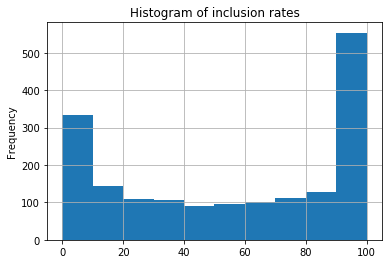

-- Mean inclusion rate 55.713941276115264
-- Median inclusion rate 60.0
--------------------------


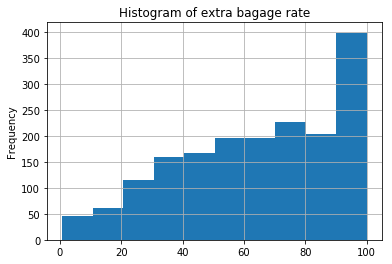

-- mean bagage rate:  64.780717108978
-- median bagage rate:  66.98
----------------


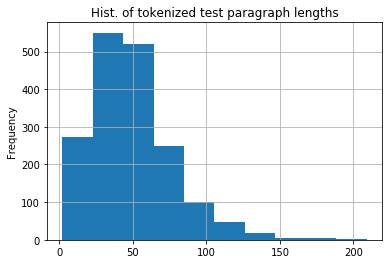

-- Mean tokenized test paragraph length  49.71597967250141
-- Median tokenized test paragraph length 46.0
-- Range of tokenized test paragraph lengths 207


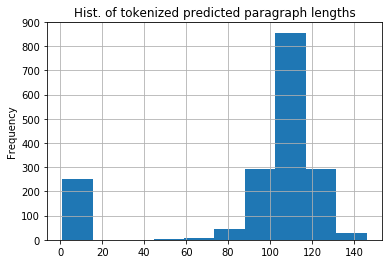

-- mean tokenized predicted parag. lenghts 93.78994918125353
-- median tokenized predicted parag. lenghts 108.0


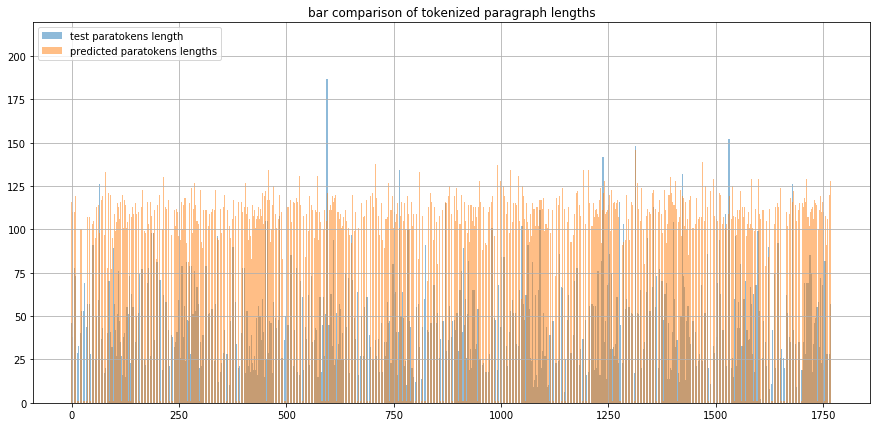

In [122]:
# report and plot the overall inclusion
print('='*30, 'Inclusion Report', '='*50)

# total inclusion rate
print(round(100*(share_rprchs_prgrph_df.tot_incl.sum())/len(share_rprchs_prgrph_df.tot_incl), 2), '% total inclusion')

# report inclusion_rate
#plt.hist(share_rprchs_prgrph_df.inclusion_pct, bins=20)
share_rprchs_prgrph_df.inclusion_pct.plot(kind = 'hist')
plt.title('Histogram of inclusion rates')
plt.grid()
plt.show()
print('-- Mean inclusion rate', np.mean(share_rprchs_prgrph_df.inclusion_pct))
print('-- Median inclusion rate', share_rprchs_prgrph_df.inclusion_pct.median())
print("--------------------------")

# report extra baggage rate
#plt.hist(share_rprchs_prgrph_df.baggage_pct)
share_rprchs_prgrph_df.baggage_pct.plot(kind = 'hist')
plt.title('Histogram of extra bagage rate')
plt.grid()
plt.show()
print('-- mean bagage rate: ', np.mean(share_rprchs_prgrph_df.baggage_pct))
print('-- median bagage rate: ', share_rprchs_prgrph_df.baggage_pct.median())
print("----------------")

# report lengths of tokenized paragraphs
#plt.hist(share_rprchs_prgrph_df.tknzd_tst_par_len)
share_rprchs_prgrph_df.tknzd_tst_par_len.plot(kind = 'hist')
plt.title('Hist. of tokenized test paragraph lengths')
plt.grid()
plt.show()
print('-- Mean tokenized test paragraph length ', np.mean(share_rprchs_prgrph_df.tknzd_tst_par_len))
print('-- Median tokenized test paragraph length', share_rprchs_prgrph_df.tknzd_tst_par_len.median())
print('-- Range of tokenized test paragraph lengths', np.max(share_rprchs_prgrph_df.tknzd_tst_par_len) - np.min(share_rprchs_prgrph_df.tknzd_tst_par_len))

#plt.hist(share_rprchs_prgrph_df.tknzd_pred_par_len)
share_rprchs_prgrph_df.tknzd_pred_par_len.plot(kind = 'hist')
plt.title('Hist. of tokenized predicted paragraph lengths')
plt.grid()
plt.show()
print('-- mean tokenized predicted parag. lenghts', np.mean(share_rprchs_prgrph_df.tknzd_pred_par_len))
print('-- median tokenized predicted parag. lenghts', share_rprchs_prgrph_df.tknzd_pred_par_len.median())
#print('-- range of tokenized predicted parag. lenghts', np.max(np.array(nominated_paratokens_lengths)) - np.min(np.array(nominated_paratokens_lengths)))

# plot overlay of each paragraph's lengths
plt.figure(figsize = (15,7))
plt.bar(height = share_rprchs_prgrph_df.tknzd_tst_par_len.fillna(np.nan), alpha = 0.5,
        x = range(len(share_rprchs_prgrph_df.paragraph_text)))
        #x = range(len(share_rprchs_prgrph_df.tknzd_tst_par_len.fillna(value = np.nan))))
plt.bar(height = share_rprchs_prgrph_df.tknzd_pred_par_len.fillna(np.nan), alpha = 0.5,
        x = range(len(share_rprchs_prgrph_df.paragraph_text)))
       #x = range(len(share_rprchs_prgrph_df.tknzd_pred_par_len.fillna(value = np.nan))))
plt.title('bar comparison of tokenized paragraph lengths')
plt.legend(['test paratokens length', 'predicted paratokens lengths'])
plt.grid()
plt.show()

## write out the csv

In [74]:
share_rprchs_prgrph_df.to_csv('hit_density_predictions.csv')

In [ ]:
assert True == False

## examine output

In [76]:
share_rprchs_prgrph_df.head(3)

,ticker,accession_number,data_key_friendly_name,text,data_value,reported_data_value,reported_units,paragraph_text,tknzd_tst_par_len,pred_par,...,inclusion_pct,baggage_pct,tknzd_pred_par_len,amount,authorization,date,count,intention,utilization,unknown
0,A,0001090872-17-000018,Share Repurchase Authorization Date,"May 28, 2015",20150528,20200000.00,ones,"On May 28, 2015 we announced that our board ...",46,interest at a fixed rate of 3.875% per annum. ...,...,10.87,95.69,116,0,0,1,0,0,0,0
1,A,0001090872-17-000018,Share Repurchase Authorization,The 2015 share repurchase program authorizes t...,1140000000,1.14,billions,"On May 28, 2015 we announced that our board ...",46,nced that our board of directors had authorize...,...,97.83,42.24,116,0,1,0,0,0,0,0
2,A,0001090872-17-000018,Share Repurchase Intention,remaining authorization to repurchase up to,610000000,610.00,millions,"Table of Contents 2016, upon the completion ...",38,ed the purchases under this authorization. on ...,...,94.74,46.36,110,0,0,0,0,1,0,0


## test components above

In [ ]:
get_tfidf_ML_paragraph(nominees, string_filing, verbose = False, inverse= True)

## test tfidf vectorizer predictions

In [ ]:
for filing in training_filings_list[0:10]:
    '''# read in an html
    with open(filing) as file:
          file_html = file.read()
    # parse html
    parsed_html = BeautifulSoup(file_html)
    # filter out the html head, css, and cast to lower case
    string_filing = parsed_html.body.text.lower()'''
    
    
    nom_pars, string_filing = define_nominated_paragraphs(filing, dkfn_kts_dict['auth_kts'], margin)
    #nom_pars[0:5]
    
    
    
    nominee = ''
    best_proba = 0.0
    for tpl in nom_pars:
        # generate par
        par = string_filing[tpl[0]:tpl[1]]
        # pre process par
        par = re.sub(r'\n+', ' ', par)
        par = re.sub(r'\s+', ' ', par)
        # tfidf_vectorize the string into a sparse matrix
        par_tfidf_vectorized = tfidf_vectorizer.transform([par])
        # if the naiver bayes prediction of classification as a given dkfn's class is new_best probability
        if nb_auth_classifier.predict(par_tfidf_vectorized)[0] == 1 and nb_auth_classifier.predict_proba(par_tfidf_vectorized)[0][1] > best_proba:
            #print(nb_auth_classifier.predict_proba(par_tfidf_vectorized))
            nominee = par
            #print(nominee)
            best_proba = nb_auth_classifier.predict_proba(par_tfidf_vectorized)[0][1]
    
    print('best probability', best_proba)
    print('-'*100)
    print(nominee)
    print('='*100)

My Results are rather bad, based on visual inspection. 
- I have a feeling this is because the tfidf vectorizer is penalizing paragraphs that have precisely those terms that are most common in the training data. 
    - Well, all I know is that tfidf assigns low scores to terms that are super frequent across documents
        - i.e. 'authorized'
    - And it assigns high scores to terms that are frequent across documents
    - the result is that if 'authorized' appeard only once in each paragraph cell it would be scored very high
        - but the more it appears in each cell the more it gets penalized
- Then naive bayes is doing something (i know not what) to the effect of:
    - given that your paragraph has 'authorized' in it, how likely is it to be an authorization dkfn, as opposed to not. 
        - since all of or most of them have 'authorized' in there it probably thinks this term is rather irrelevant. 
        
 The problem is that my models are optimized to distinguish between relevant paragraphs, and to classify them based on their minor differences.
 - so it rewards paragraphs that have terms that are very rare in the training paragraphs
 - it's optimized to "split" hairs between good paragraphs, so it's trying to get as far away as possible from the "average" good paragraph, while still having "a toe" in the domain of their key tokens. 
 
If the model had been fit on noise and signal, it would be good at identifying noise. But since it was fit on signals 1 - 7, it is biased towards picking noise that is as unsimilar as possible to signals 1-7.

I, think... 🤔 

If my hypothesis is correct, then a count vectroizer should reward paragraphs that are most similar to training paragraphs
        

# Let's try out the results with a count vectorizer

In [ ]:
count_vectorizer = CountVectorizer(stop_words='english')
count_train = count_vectorizer.fit_transform(X_train)
count_test = count_vectorizer.transform(X_test)
second_nb_classifier = MultinomialNB()


In [ ]:
## Try out count vectorizer on 'authorization'
y_train = share_rprchs_prgrph_df.authorization[[ix in y_train_ix for ix in share_rprchs_prgrph_df.index]]

In [ ]:
y_test = share_rprchs_prgrph_df.authorization[[ix in y_test_ix for ix in share_rprchs_prgrph_df.index]]

In [ ]:
second_nb_classifier.fit(count_train, y_train)

In [ ]:
count_predictions = second_nb_classifier.predict(count_test)
metrics.accuracy_score(y_test, count_predictions)

In [ ]:
for filing in training_filings_list[0:10]:
    # read in an html
    with open(filing) as file:
          file_html = file.read()
    # parse html
    parsed_html = BeautifulSoup(file_html)
    # filter out the html head, css, and cast to lower case
    string_filing = parsed_html.body.text.lower()
    
    
    
    nom_pars = define_nominated_paragraphs(filing, dkfn_kts_dict['auth_kts'], margin)
    #nom_pars[0:5]
    
    
    
    nominee = ''
    best_proba = 0.0
    for tpl in nom_pars:
        # generate par
        par = string_filing[tpl[0]:tpl[1]]
        # pre process par
        par = re.sub(r'\n+', ' ', par)
        par = re.sub(r'\s+', ' ', par)
        
        # tfidf_vectorize the string into a sparse matrix
        #par_tfidf_vectorized = tfidf_vectorizer.transform([par])
        
        # count_vectorize the string into a sparse matrix
        vectorized_par = count_vectorizer.transform([par])
        
        # if the naiver bayes prediction of classification as a given dkfn's class is new_best probability
        if second_nb_classifier.predict(vectorized_par)[0] == 1 and second_nb_classifier.predict_proba(vectorized_par)[0][1] > best_proba:
            #print(nb_auth_classifier.predict_proba(par_tfidf_vectorized))
            nominee = par
            #print(nominee)
            best_proba = second_nb_classifier.predict_proba(vectorized_par)[0][1]
    
    print('best probability', best_proba)
    print('-'*100)
    print(nominee)
    print('='*100)

Again, the problem is that the model is optimized to reward the hairsplit differences between 7 signals. 
- so since 'authorization' appears in most of the 7 signals, it's relevance is ignored or downplayed
- whereas if 'further' appears more often in authorization signal than in the others, then it's going to pick noise paragraphs that have a hig count of the term 'further'

# 😜 if my models are so good at being bad, then what if I use the opposite of their prediction?

Ok, well let's try it for the count vectorizer. 
- although, I guess the key toks would get us in the "weather system"
- but the inverse count vecotrized prediction would reward the terms that were frequent across all of a dkfn's 'authorization' training paragraphs...

This did not work well for the inverse count prediction. I got 0/10 hits on 'authorized'

Try it again with the prediction being true, but then select the one with the lowes probability of being true. 
- no hits on 'authorized'
- 1/10 for 'repurchased'

😂 that worked for 5/10 with the tfidf on 'authorized'
- got 11/20 for 'authorized' with the inverse tfidf = 55%
- got 25/40 for 'authorized' with the inverse tfidf = 62.5%

So what is going on?
- if we think of each dkfn's paragraph cluster as a 'weather system' then the densest clouds represent the overlap, the commonalities between all that dkfn's paragraphs. all of that signals commonalities
- the tk_hits defines the 'weather system' 
- the tfidf rewards the 'edgiest' of the points, the outlier signals.
- the inverse tfidf rewards not what the dkfn paragraphs have in common, but rather what they have in common with the other signals. 
    - so it does a good job of getting us into the overlap between the signlas, it sort of defines the generica 'mean' signal. But it is not equipped to distinguish between noise and a given signal. 
    - it is only equipped to discern between the 7 signals. 
    
analogy:
- if i trained three models for classifying three instruments
    - rough electric guitar
        - the guitar model would determine that what stood out most about the electric guitar was it's low end growl and distortion
    - flute
       - the flute model would reward the sound of blowing
    - and drums
        - the drum model would reward percussion
- all three models would consider, rythm, and melody irrelevant (because all three instruments have those features).
- when 'released into the wild' 
    - the guitar model would prefer a diesel engine to an actual electric guitar
    - the flute model would prefer a tornado instead of any wind instrument
    - the drum model would prefer a jackhammer or construction zone over any percussion instrument
- the models would go out of their way to pass over instruments.


In [ ]:
for filing in training_filings_list[0:40]:
    # read in an html
    with open(filing) as file:
          file_html = file.read()
    # parse html
    parsed_html = BeautifulSoup(file_html)
    # filter out the html head, css, and cast to lower case
    string_filing = parsed_html.body.text.lower()
    
    
    
    nom_pars = define_nominated_paragraphs(filing, dkfn_kts_dict['auth_kts'], margin)
    #nom_pars[0:5]
    
    
    
    nominee = ''
    best_proba = 0.0
    for tpl in nom_pars:
        # generate par
        par = string_filing[tpl[0]:tpl[1]]
        # pre process par
        par = re.sub(r'\n+', ' ', par)
        par = re.sub(r'\s+', ' ', par)
        # tfidf_vectorize the string into a sparse matrix
        par_tfidf_vectorized = tfidf_vectorizer.transform([par])
        # if the naiver bayes prediction of classification as a given dkfn's class is new_best probability
        if nb_auth_classifier.predict(par_tfidf_vectorized)[0] == 0 and nb_auth_classifier.predict_proba(par_tfidf_vectorized)[0][0] > best_proba:
            #print(nb_auth_classifier.predict_proba(par_tfidf_vectorized))
            nominee = par
            #print(nominee)
            best_proba = nb_auth_classifier.predict_proba(par_tfidf_vectorized)[0][0]
    
    print('best probability', best_proba)
    print('-'*100)
    print(nominee)
    print('='*100)